In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
from sklearn.decomposition import PCA
from tqdm import tqdm
from numpy import linalg as LA
import pickle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_start = 1
pred_end = 2

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()[:, pred_start:pred_end]
pro_s1d2 = pro_s1d2.X.toarray()[:, pred_start:pred_end]
pro_s1d3 = pro_s1d3.X.toarray()[:, pred_start:pred_end]
pro_s2d1 = pro_s2d1.X.toarray()[:, pred_start:pred_end]
pro_s2d4 = pro_s2d4.X.toarray()[:, pred_start:pred_end]
pro_s2d5 = pro_s2d5.X.toarray()[:, pred_start:pred_end]

pro_s3d1 = pro_s3d1.X.toarray()[:, pred_start:pred_end]
pro_s3d6 = pro_s3d6.X.toarray()[:, pred_start:pred_end]
pro_s3d7 = pro_s3d7.X.toarray()[:, pred_start:pred_end]

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()[:, pred_start:pred_end]
pro_s4d8 = pro_s4d8.X.toarray()[:, pred_start:pred_end]
pro_s4d9 = pro_s4d9.X.toarray()[:, pred_start:pred_end]

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 1)


In [17]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [18]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [19]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [20]:
train_input = train_input + val_input
train_output = train_output + val_output

In [21]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [22]:
RNA_s1d1 = torch.from_numpy(RNA_s1d1)
RNA_s1d2 = torch.from_numpy(RNA_s1d2)
RNA_s1d3 = torch.from_numpy(RNA_s1d3)
RNA_s2d1 = torch.from_numpy(RNA_s2d1)
RNA_s2d4 = torch.from_numpy(RNA_s2d4)
RNA_s2d5 = torch.from_numpy(RNA_s2d5)
RNA_s3d1 = torch.from_numpy(RNA_s3d1)
RNA_s3d6 = torch.from_numpy(RNA_s3d6)
RNA_s3d7 = torch.from_numpy(RNA_s3d7)
RNA_s4d1 = torch.from_numpy(RNA_s4d1)
RNA_s4d8 = torch.from_numpy(RNA_s4d8)
RNA_s4d9 = torch.from_numpy(RNA_s4d9)

In [23]:
pro_s1d1 = torch.from_numpy(pro_s1d1)
pro_s1d2 = torch.from_numpy(pro_s1d2)
pro_s1d3 = torch.from_numpy(pro_s1d3)
pro_s2d1 = torch.from_numpy(pro_s2d1)
pro_s2d4 = torch.from_numpy(pro_s2d4)
pro_s2d5 = torch.from_numpy(pro_s2d5)
pro_s3d1 = torch.from_numpy(pro_s3d1)
pro_s3d6 = torch.from_numpy(pro_s3d6)
pro_s3d7 = torch.from_numpy(pro_s3d7)
pro_s4d1 = torch.from_numpy(pro_s4d1)
pro_s4d8 = torch.from_numpy(pro_s4d8)
pro_s4d9 = torch.from_numpy(pro_s4d9)

In [24]:
train_input = torch.from_numpy(train_input)
val_input = torch.from_numpy(val_input)
test_input = torch.from_numpy(test_input)

train_output = torch.from_numpy(train_output)
val_output = torch.from_numpy(val_output)
test_output = torch.from_numpy(test_output)

In [25]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

print(train_output.shape)
print(val_output.shape)
print(test_output.shape)

torch.Size([66175, 13953])
torch.Size([28921, 13953])
torch.Size([1000, 13953])
torch.Size([66175, 1])
torch.Size([28921, 1])
torch.Size([1000, 1])


In [26]:
def top_samples(source, target, num):
    distances = LA.norm(source-target, axis=1)
    temp_list = []
    for i in range(len(distances)):
        temp_list.append([distances[i], i])
    temp_list.sort()
    return [ele[1] for ele in temp_list[:num]]

In [27]:
input_near_ind_list = []
output_near_ind_list = []

for i in tqdm(range(test_input.shape[0])):
    near_neig_ind = top_samples(test_input[i], train_input, 5)
    input_near_ind_list.append(train_input[near_neig_ind])
    output_near_ind_list.append(train_output[near_neig_ind])
    
input_near = np.concatenate(input_near_ind_list, axis= 0)
output_near = np.concatenate(output_near_ind_list, axis= 0)

100%|██████████| 1000/1000 [29:52<00:00,  1.79s/it]


In [28]:
# with open(r"input_near_eucli.pickle", "wb") as output_file:
#     pickle.dump(input_near, output_file)
    
# with open(r"output_near_eucli.pickle", "wb") as output_file:
#     pickle.dump(output_near, output_file)

In [29]:
# with open(r"input_near_eucli.pickle", "rb") as input_file:
#     input_near = pickle.load(input_file)
    
# with open(r"output_near_eucli.pickle", "rb") as input_file:
#     output_near = pickle.load(input_file)

In [30]:
RNA_s1d1 = RNA_s1d1.float()
RNA_s1d2 = RNA_s1d2.float()
RNA_s1d3 = RNA_s1d3.float()
RNA_s2d1 = RNA_s2d1.float()
RNA_s2d4 = RNA_s2d4.float()
RNA_s2d5 = RNA_s2d5.float()
RNA_s3d1 = RNA_s3d1.float()
RNA_s3d6 = RNA_s3d6.float()
RNA_s3d7 = RNA_s3d7.float()
RNA_s4d1 = RNA_s4d1.float()
RNA_s4d8 = RNA_s4d8.float()
RNA_s4d9 = RNA_s4d9.float()

pro_s1d1 = pro_s1d1.float()
pro_s1d2 = pro_s1d2.float()
pro_s1d3 = pro_s1d3.float()
pro_s2d1 = pro_s2d1.float()
pro_s2d4 = pro_s2d4.float()
pro_s2d5 = pro_s2d5.float()
pro_s3d1 = pro_s3d1.float()
pro_s3d6 = pro_s3d6.float()
pro_s3d7 = pro_s3d7.float()
pro_s4d1 = pro_s4d1.float()
pro_s4d8 = pro_s4d8.float()
pro_s4d9 = pro_s4d9.float()

In [31]:
train_input = train_input.float()
val_input = val_input.float()
test_input = test_input.float()

train_output = train_output.float()
val_output = val_output.float()
test_output = test_output.float()

In [32]:
# input_near = input_near.float()
# output_near = output_near.float()

In [33]:
RNA_s1d1 = RNA_s1d1.to(device)
RNA_s1d2 = RNA_s1d2.to(device)
RNA_s1d3 = RNA_s1d3.to(device)
RNA_s2d1 = RNA_s2d1.to(device)
RNA_s2d4 = RNA_s2d4.to(device)
RNA_s2d5 = RNA_s2d5.to(device)
RNA_s3d1 = RNA_s3d1.to(device)
RNA_s3d6 = RNA_s3d6.to(device)
RNA_s3d7 = RNA_s3d7.to(device)
RNA_s4d1 = RNA_s4d1.to(device)
RNA_s4d8 = RNA_s4d8.to(device)
RNA_s4d9 = RNA_s4d9.to(device)

pro_s1d1 = pro_s1d1.to(device)
pro_s1d2 = pro_s1d2.to(device)
pro_s1d3 = pro_s1d3.to(device)
pro_s2d1 = pro_s2d1.to(device)
pro_s2d4 = pro_s2d4.to(device)
pro_s2d5 = pro_s2d5.to(device)
pro_s3d1 = pro_s3d1.to(device)
pro_s3d6 = pro_s3d6.to(device)
pro_s3d7 = pro_s3d7.to(device)
pro_s4d1 = pro_s4d1.to(device)
pro_s4d8 = pro_s4d8.to(device)
pro_s4d9 = pro_s4d9.to(device)

In [34]:
train_input = train_input.to(device)
val_input = val_input.to(device)
test_input = test_input.to(device)

train_output = train_output.to(device)
val_output = val_output.to(device)
test_output = test_output.to(device)

In [35]:
# input_near = torch.from_numpy(input_near)
# output_near = torch.from_numpy(output_near)

In [36]:
input_near = torch.from_numpy(input_near)
output_near = torch.from_numpy(output_near)

input_near = input_near.to(device)
output_near = output_near.to(device)

In [37]:
input_feature = RNA_s1d1.shape[1]

In [38]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, 1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [39]:
PATH = 'No_norm_model_RNA_pro'

In [40]:
def fit(num_epochs, model, loss_fn, RNA, pro):
    train_ds = TensorDataset(RNA, pro)
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            near_pred = model(input_near)
            near_loss = loss_fn(near_pred, output_near)
            near_loss = torch.sqrt(near_loss)
            near_loss = near_loss.cpu().detach().numpy()
            
            s1d1_pred = model(RNA_s1d1)
            s1d1_loss = loss_fn(s1d1_pred, pro_s1d1)
            s1d1_loss = torch.sqrt(s1d1_loss)
            s1d1_loss = s1d1_loss.cpu().detach().numpy()
            
            s1d2_pred = model(RNA_s1d2)
            s1d2_loss = loss_fn(s1d2_pred, pro_s1d2)
            s1d2_loss = torch.sqrt(s1d2_loss)
            s1d2_loss = s1d2_loss.cpu().detach().numpy()
            
            s1d3_pred = model(RNA_s1d3)
            s1d3_loss = loss_fn(s1d3_pred, pro_s1d3)
            s1d3_loss = torch.sqrt(s1d3_loss)
            s1d3_loss = s1d3_loss.cpu().detach().numpy()
            
            s2d1_pred = model(RNA_s2d1)
            s2d1_loss = loss_fn(s2d1_pred, pro_s2d1)
            s2d1_loss = torch.sqrt(s2d1_loss)
            s2d1_loss = s2d1_loss.cpu().detach().numpy()
            
            s2d4_pred = model(RNA_s2d4)
            s2d4_loss = loss_fn(s2d4_pred, pro_s2d4)
            s2d4_loss = torch.sqrt(s2d4_loss)
            s2d4_loss = s2d4_loss.cpu().detach().numpy()
            
            s2d5_pred = model(RNA_s2d5)
            s2d5_loss = loss_fn(s2d5_pred, pro_s2d5)
            s2d5_loss = torch.sqrt(s2d5_loss)
            s2d5_loss = s2d5_loss.cpu().detach().numpy()
            
            s3d1_pred = model(RNA_s3d1)
            s3d1_loss = loss_fn(s3d1_pred, pro_s3d1)
            s3d1_loss = torch.sqrt(s3d1_loss)
            s3d1_loss = s3d1_loss.cpu().detach().numpy()
            
            s3d6_pred = model(RNA_s3d6)
            s3d6_loss = loss_fn(s3d6_pred, pro_s3d6)
            s3d6_loss = torch.sqrt(s3d6_loss)
            s3d6_loss = s3d6_loss.cpu().detach().numpy()
            
            s3d7_pred = model(RNA_s3d7)
            s3d7_loss = loss_fn(s3d7_pred, pro_s3d7)
            s3d7_loss = torch.sqrt(s3d7_loss)
            s3d7_loss = s3d7_loss.cpu().detach().numpy()

            s4d1_pred = model(RNA_s4d1)
            s4d1_loss = loss_fn(s4d1_pred, pro_s4d1)
            s4d1_loss = torch.sqrt(s4d1_loss)
            s4d1_loss = s4d1_loss.cpu().detach().numpy()
            
            s4d8_pred = model(RNA_s4d8)
            s4d8_loss = loss_fn(s4d8_pred, pro_s4d8)
            s4d8_loss = torch.sqrt(s4d8_loss)
            s4d8_loss = s4d8_loss.cpu().detach().numpy()
            
            s4d9_pred = model(RNA_s4d9)
            s4d9_loss = loss_fn(s4d9_pred, pro_s4d9)
            s4d9_loss = torch.sqrt(s4d9_loss)
            s4d9_loss = s4d9_loss.cpu().detach().numpy()
            

            test_loss = ((s4d1_loss**2*s4d1_pred.shape[0] + s4d8_loss**2*s4d8_pred.shape[0] + s4d9_loss**2*s4d9_pred.shape[0])/(s4d1_pred.shape[0]+s4d8_pred.shape[0]+s4d9_pred.shape[0]))**0.5
            
            print('Epoch ', epoch, 'near loss:', near_loss, 's1d1: ', s1d1_loss, 's1d2: ', s1d2_loss, 's1d3: ', s1d3_loss, 's2d1:', s2d1_loss, 's2d4:',
                  s2d4_loss, 's2d5:', s2d5_loss, 's3d1:', s3d1_loss, 's3d6:', s3d6_loss, 's3d7:', s3d7_loss, 's4d1:', s4d1_loss, 's4d8:', s4d8_loss, 's4d9:', s4d9_loss, 'test loss:', test_loss)
            
        if epoch % 1000 == 0:
            figure, ax = plt.subplots(1, 13, figsize = (33, 3))
            for i in range(1):
                
                ax[0].scatter(output_near.cpu().detach().numpy()[:, 0], near_pred.cpu().detach().numpy()[:, 0], c='purple', s = 30, alpha=0.05)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Nearest neighbor result')
                ax[0].set_xlabel('true')
                ax[0].set_ylabel('pred')
                
                ax[1].scatter(pro_s1d1.cpu().detach().numpy()[:, 0], s1d1_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('s1d1 result')
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(pro_s1d2.cpu().detach().numpy()[:, 0], s1d2_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('s1d2 result')
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')

                ax[3].scatter(pro_s1d3.cpu().detach().numpy()[:, 0], s1d3_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[3].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[3].set_title('s1d3 result')
                ax[3].set_xlabel('true')
                ax[3].set_ylabel('pred')
                
                ax[4].scatter(pro_s2d1.cpu().detach().numpy()[:, 0], s2d1_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[4].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[4].set_title('s2d1 result')
                ax[4].set_xlabel('true')
                ax[4].set_ylabel('pred')

                ax[5].scatter(pro_s2d4.cpu().detach().numpy()[:, 0], s2d4_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[5].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[5].set_title('s2d4 result')
                ax[5].set_xlabel('true')
                ax[5].set_ylabel('pred')

                ax[6].scatter(pro_s2d5.cpu().detach().numpy()[:, 0], s2d5_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[6].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[6].set_title('s2d5 result')
                ax[6].set_xlabel('true')
                ax[6].set_ylabel('pred')
                
                ax[7].scatter(pro_s3d1.cpu().detach().numpy()[:, 0], s3d1_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[7].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[7].set_title('s3d1 result')
                ax[7].set_xlabel('true')
                ax[7].set_ylabel('pred')

                ax[8].scatter(pro_s3d6.cpu().detach().numpy()[:, 0], s3d6_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[8].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[8].set_title('s3d6 result')
                ax[8].set_xlabel('true')
                ax[8].set_ylabel('pred')

                ax[9].scatter(pro_s3d7.cpu().detach().numpy()[:, 0], s3d7_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[9].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[9].set_title('s3d7 result')
                ax[9].set_xlabel('true')
                ax[9].set_ylabel('pred')
                
                ax[10].scatter(pro_s4d1.cpu().detach().numpy()[:, 0], s4d1_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[10].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[10].set_title('s4d1 result')
                ax[10].set_xlabel('true')
                ax[10].set_ylabel('pred')

                ax[11].scatter(pro_s4d8.cpu().detach().numpy()[:, 0], s4d8_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[11].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[11].set_title('s4d8 result')
                ax[11].set_xlabel('true')
                ax[11].set_ylabel('pred')

                ax[12].scatter(pro_s4d9.cpu().detach().numpy()[:, 0], s4d9_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[12].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[12].set_title('s4d9 result')
                ax[12].set_xlabel('true')
                ax[12].set_ylabel('pred')
            
            plt.show()
    return

Epoch  0 near loss: 1.6747546 s1d1:  1.8132482 s1d2:  1.9584924 s1d3:  1.7189941 s2d1: 0.67079747 s2d4: 1.2600689 s2d5: 1.20865 s3d1: 0.48521084 s3d6: 1.2530717 s3d7: 1.4011563 s4d1: 1.5983245 s4d8: 1.9159703 s4d9: 1.0740787 test loss: 1.463782192335548


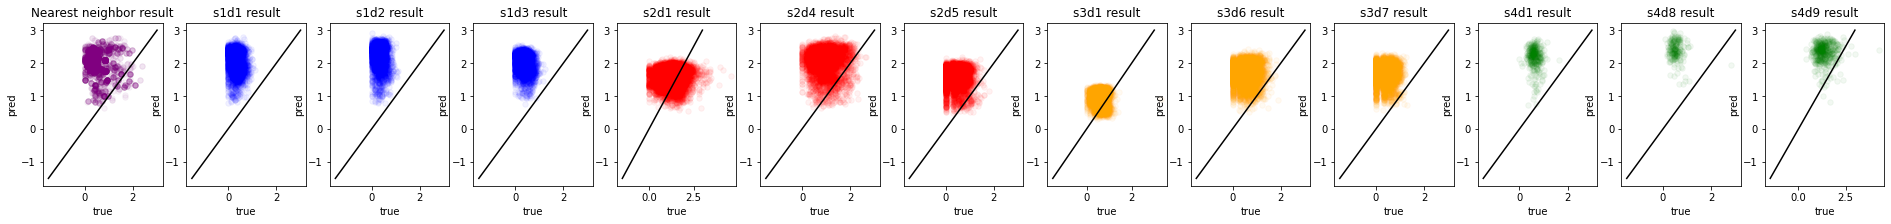

Epoch  100 near loss: 0.14955914 s1d1:  0.28551686 s1d2:  0.21041816 s1d3:  0.24299258 s2d1: 0.773624 s2d4: 0.6144056 s2d5: 0.3246681 s3d1: 0.25730386 s3d6: 0.36473516 s3d7: 0.30496705 s4d1: 0.27223912 s4d8: 0.27402654 s4d9: 0.92916894 test loss: 0.6607403228794346
Epoch  200 near loss: 0.07462077 s1d1:  0.2801253 s1d2:  0.20925844 s1d3:  0.24431293 s2d1: 0.7450367 s2d4: 0.58450127 s2d5: 0.32011193 s3d1: 0.27738458 s3d6: 0.36107868 s3d7: 0.3065824 s4d1: 0.2720429 s4d8: 0.28581265 s4d9: 0.93588185 test loss: 0.6660740108460024
Epoch  300 near loss: 0.045556612 s1d1:  0.2855568 s1d2:  0.2146599 s1d3:  0.25086284 s2d1: 0.72599757 s2d4: 0.5691864 s2d5: 0.3265124 s3d1: 0.2856558 s3d6: 0.36273745 s3d7: 0.31381083 s4d1: 0.26926088 s4d8: 0.28390336 s4d9: 0.9272304 test loss: 0.6599454646457236
Epoch  400 near loss: 0.05100319 s1d1:  0.30593643 s1d2:  0.22738527 s1d3:  0.2702911 s2d1: 0.69669104 s2d4: 0.5489975 s2d5: 0.34533557 s3d1: 0.29971522 s3d6: 0.3722953 s3d7: 0.331164 s4d1: 0.26138797 s4

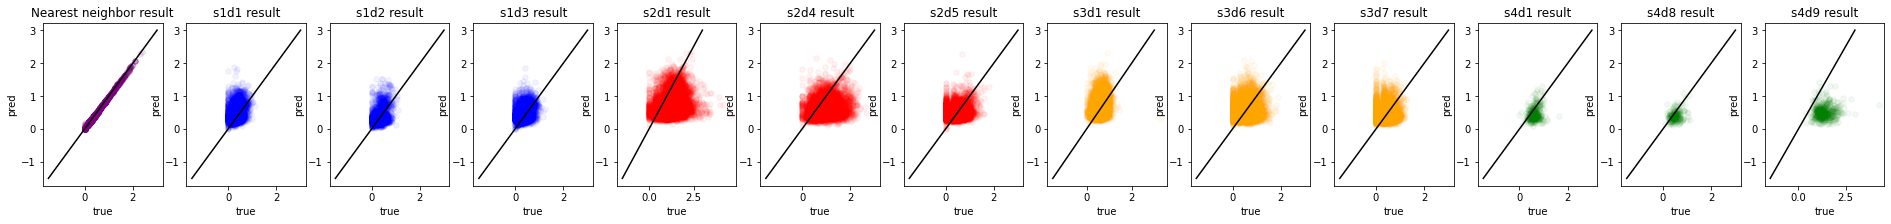

Epoch  1100 near loss: 0.013602435 s1d1:  0.2829376 s1d2:  0.21712379 s1d3:  0.25107485 s2d1: 0.7250724 s2d4: 0.57153827 s2d5: 0.32900703 s3d1: 0.30105615 s3d6: 0.3635115 s3d7: 0.31738988 s4d1: 0.27830604 s4d8: 0.28794548 s4d9: 0.94347537 test loss: 0.6720190040217208
Epoch  1200 near loss: 0.0099755665 s1d1:  0.28677142 s1d2:  0.21934181 s1d3:  0.2538916 s2d1: 0.7208653 s2d4: 0.5683149 s2d5: 0.3310296 s3d1: 0.30372196 s3d6: 0.3646169 s3d7: 0.32032284 s4d1: 0.276557 s4d8: 0.28690147 s4d9: 0.9380656 test loss: 0.6681984187194243
Epoch  1300 near loss: 0.014539018 s1d1:  0.28075522 s1d2:  0.21626984 s1d3:  0.24926437 s2d1: 0.7254835 s2d4: 0.57262045 s2d5: 0.32921883 s3d1: 0.3015427 s3d6: 0.36353207 s3d7: 0.31753653 s4d1: 0.27945882 s4d8: 0.28998736 s4d9: 0.94696844 test loss: 0.6746106580745244
Epoch  1400 near loss: 0.0103834 s1d1:  0.2848047 s1d2:  0.21811 s1d3:  0.2522016 s2d1: 0.7225982 s2d4: 0.5702564 s2d5: 0.3303366 s3d1: 0.30391046 s3d6: 0.36439463 s3d7: 0.31964973 s4d1: 0.2785438

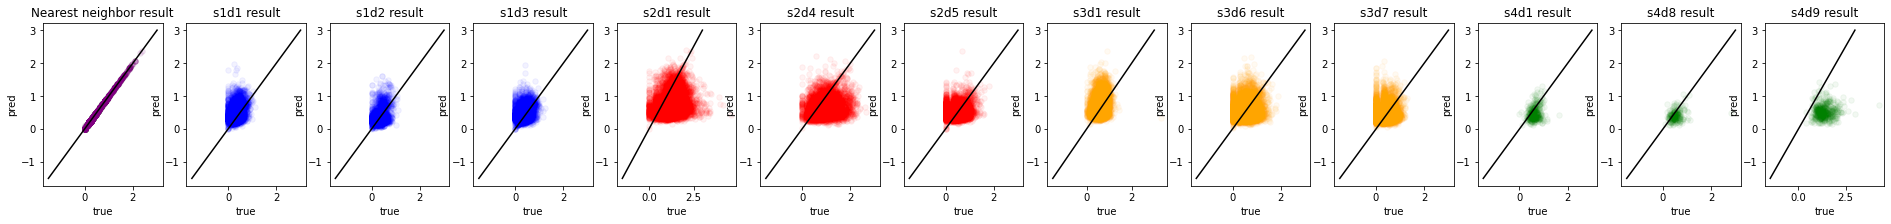

Epoch  2100 near loss: 0.006285809 s1d1:  0.28477034 s1d2:  0.21836558 s1d3:  0.2518626 s2d1: 0.7198307 s2d4: 0.56848043 s2d5: 0.33261934 s3d1: 0.30583686 s3d6: 0.36528406 s3d7: 0.32119638 s4d1: 0.27802223 s4d8: 0.2888789 s4d9: 0.9396139 test loss: 0.6695749582770749
Epoch  2200 near loss: 0.0068851924 s1d1:  0.28761694 s1d2:  0.21955718 s1d3:  0.25432602 s2d1: 0.7161822 s2d4: 0.5662667 s2d5: 0.33443478 s3d1: 0.30762005 s3d6: 0.36570093 s3d7: 0.32279837 s4d1: 0.2755759 s4d8: 0.2864162 s4d9: 0.93429416 test loss: 0.6655895257113519
Epoch  2300 near loss: 0.008683203 s1d1:  0.28192085 s1d2:  0.21711569 s1d3:  0.24974261 s2d1: 0.7226966 s2d4: 0.57089263 s2d5: 0.33102536 s3d1: 0.30530646 s3d6: 0.3646327 s3d7: 0.31968576 s4d1: 0.2794441 s4d8: 0.29046395 s4d9: 0.9446567 test loss: 0.6731618868030572
Epoch  2400 near loss: 0.008213407 s1d1:  0.2820913 s1d2:  0.21702524 s1d3:  0.249653 s2d1: 0.7226734 s2d4: 0.57076013 s2d5: 0.3310486 s3d1: 0.30428952 s3d6: 0.36416253 s3d7: 0.3192592 s4d1: 0.27

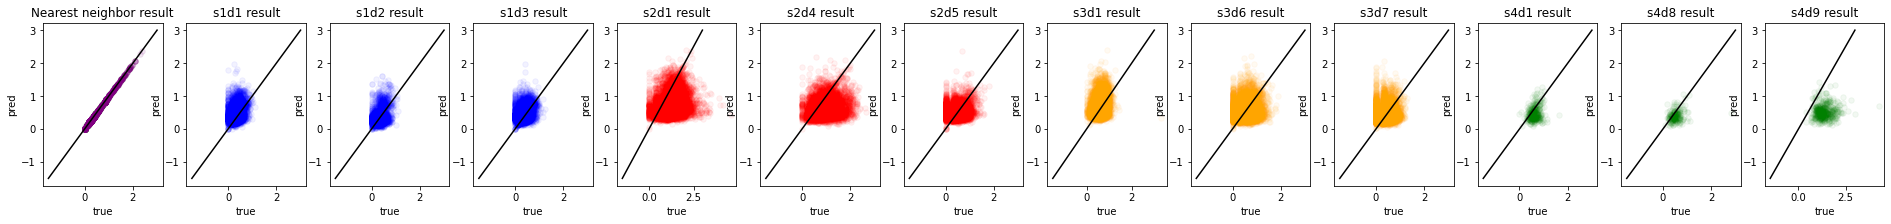

Epoch  3100 near loss: 0.006839514 s1d1:  0.28299513 s1d2:  0.21751079 s1d3:  0.25078115 s2d1: 0.71839845 s2d4: 0.56865513 s2d5: 0.33329976 s3d1: 0.30520928 s3d6: 0.36445028 s3d7: 0.3205841 s4d1: 0.27586076 s4d8: 0.28845114 s4d9: 0.9371353 test loss: 0.6676409949691987
Epoch  3200 near loss: 0.008940045 s1d1:  0.28264615 s1d2:  0.21757726 s1d3:  0.2506459 s2d1: 0.7223618 s2d4: 0.5719721 s2d5: 0.3311698 s3d1: 0.3048057 s3d6: 0.36449438 s3d7: 0.3189665 s4d1: 0.27929804 s4d8: 0.29066 s4d9: 0.9438537 test loss: 0.6726419089723608
Epoch  3300 near loss: 0.0064085084 s1d1:  0.28912082 s1d2:  0.2206571 s1d3:  0.25592342 s2d1: 0.7149944 s2d4: 0.5663842 s2d5: 0.3355574 s3d1: 0.30830598 s3d6: 0.36662713 s3d7: 0.3230971 s4d1: 0.27589738 s4d8: 0.28797427 s4d9: 0.9318481 test loss: 0.6641977754137997
Epoch  3400 near loss: 0.012836953 s1d1:  0.2918158 s1d2:  0.22203766 s1d3:  0.25807333 s2d1: 0.710156 s2d4: 0.56327665 s2d5: 0.33856404 s3d1: 0.31221536 s3d6: 0.3685136 s3d7: 0.32616037 s4d1: 0.274591

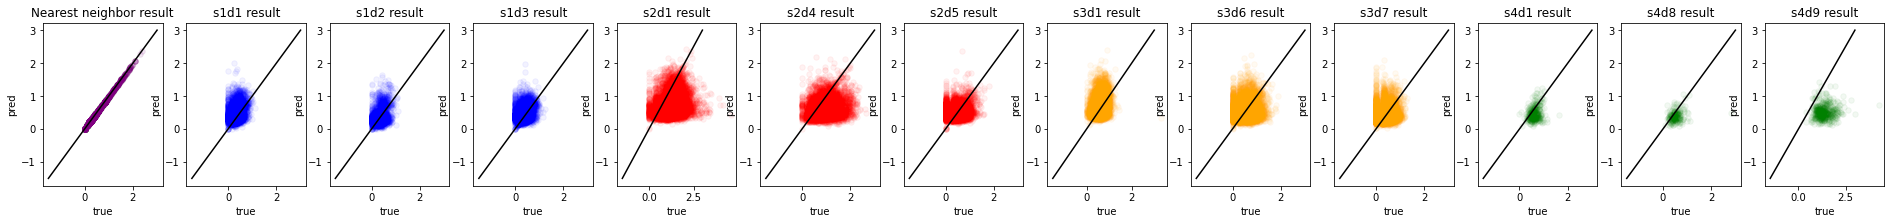

Epoch  4100 near loss: 0.0067019504 s1d1:  0.2848485 s1d2:  0.21846512 s1d3:  0.25243944 s2d1: 0.7197264 s2d4: 0.5707319 s2d5: 0.3327622 s3d1: 0.3056324 s3d6: 0.36531952 s3d7: 0.31983146 s4d1: 0.27757585 s4d8: 0.29033867 s4d9: 0.9391563 test loss: 0.6693491037419053
Epoch  4200 near loss: 0.006692333 s1d1:  0.2830926 s1d2:  0.21779098 s1d3:  0.2509587 s2d1: 0.7207176 s2d4: 0.57139635 s2d5: 0.33232224 s3d1: 0.30618125 s3d6: 0.36523718 s3d7: 0.31962615 s4d1: 0.2785401 s4d8: 0.29134816 s4d9: 0.94154227 test loss: 0.6711099289730197
Epoch  4300 near loss: 0.0038569935 s1d1:  0.28699017 s1d2:  0.21976508 s1d3:  0.25406057 s2d1: 0.7166525 s2d4: 0.5686986 s2d5: 0.3345962 s3d1: 0.30842847 s3d6: 0.36665818 s3d7: 0.32192189 s4d1: 0.27731642 s4d8: 0.29072422 s4d9: 0.9373398 test loss: 0.6681780525634076
Epoch  4400 near loss: 0.0035163087 s1d1:  0.2870917 s1d2:  0.21975416 s1d3:  0.254222 s2d1: 0.71694773 s2d4: 0.56926775 s2d5: 0.3342529 s3d1: 0.30822858 s3d6: 0.36666963 s3d7: 0.3215323 s4d1: 0.2

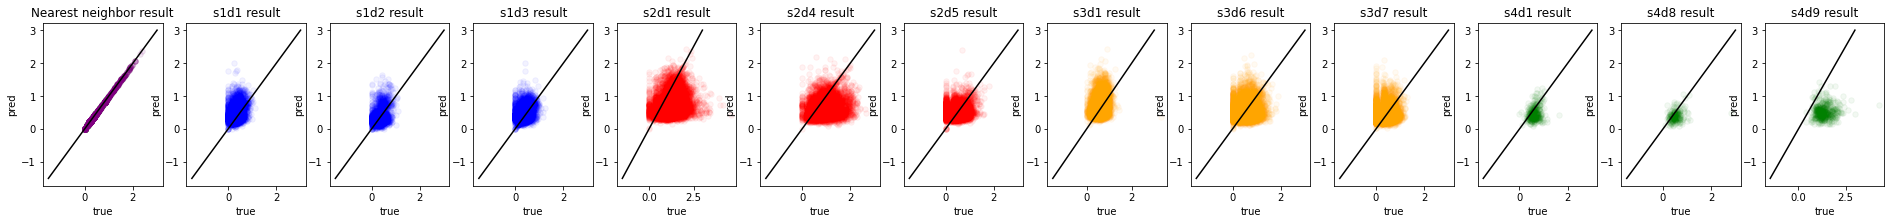

Epoch  5100 near loss: 0.0052463934 s1d1:  0.2857602 s1d2:  0.21950735 s1d3:  0.25399724 s2d1: 0.7176978 s2d4: 0.5696783 s2d5: 0.3340776 s3d1: 0.3070537 s3d6: 0.36577928 s3d7: 0.32077068 s4d1: 0.2763146 s4d8: 0.2902644 s4d9: 0.9360482 test loss: 0.6671662196187218
Epoch  5200 near loss: 0.0037996448 s1d1:  0.28716454 s1d2:  0.22003731 s1d3:  0.25470406 s2d1: 0.7159781 s2d4: 0.56791806 s2d5: 0.33498156 s3d1: 0.30799177 s3d6: 0.366428 s3d7: 0.3218155 s4d1: 0.27535748 s4d8: 0.28944138 s4d9: 0.9332441 test loss: 0.6651539002359763
Epoch  5300 near loss: 0.0051916004 s1d1:  0.28400838 s1d2:  0.21861404 s1d3:  0.25237727 s2d1: 0.7185706 s2d4: 0.5705317 s2d5: 0.3336361 s3d1: 0.30708978 s3d6: 0.36567643 s3d7: 0.32040626 s4d1: 0.27752194 s4d8: 0.29116675 s4d9: 0.9392377 test loss: 0.6694685052328513
Epoch  5400 near loss: 0.0063980836 s1d1:  0.28350136 s1d2:  0.21807171 s1d3:  0.25167447 s2d1: 0.71924376 s2d4: 0.5715503 s2d5: 0.33307528 s3d1: 0.30731806 s3d6: 0.36580816 s3d7: 0.3196925 s4d1: 0.

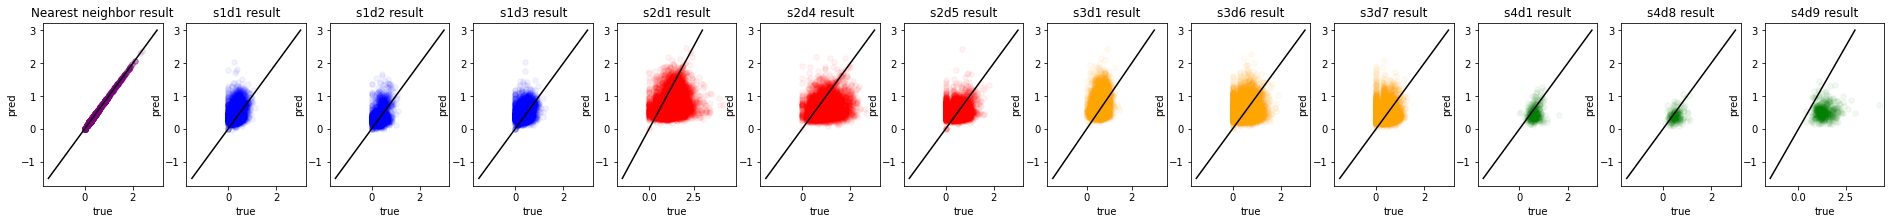

Epoch  6100 near loss: 0.0037164295 s1d1:  0.28710884 s1d2:  0.21993662 s1d3:  0.25445312 s2d1: 0.7159735 s2d4: 0.568854 s2d5: 0.33465058 s3d1: 0.30910087 s3d6: 0.36691183 s3d7: 0.32183224 s4d1: 0.27605724 s4d8: 0.29037726 s4d9: 0.9353141 test loss: 0.6666680519169085
Epoch  6200 near loss: 0.00362614 s1d1:  0.28418204 s1d2:  0.21871227 s1d3:  0.25251484 s2d1: 0.71795255 s2d4: 0.57080424 s2d5: 0.33426657 s3d1: 0.30734217 s3d6: 0.3662662 s3d7: 0.32028034 s4d1: 0.27713388 s4d8: 0.29181927 s4d9: 0.93759197 test loss: 0.6684139347325311
Epoch  6300 near loss: 0.005668529 s1d1:  0.2861002 s1d2:  0.21954611 s1d3:  0.25380602 s2d1: 0.71816355 s2d4: 0.57107216 s2d5: 0.33390203 s3d1: 0.30832165 s3d6: 0.36656845 s3d7: 0.3203321 s4d1: 0.2769215 s4d8: 0.29131696 s4d9: 0.9381002 test loss: 0.6686664548610327
Epoch  6400 near loss: 0.0030760702 s1d1:  0.2868341 s1d2:  0.21967657 s1d3:  0.25417638 s2d1: 0.71605074 s2d4: 0.5695652 s2d5: 0.33505413 s3d1: 0.30945715 s3d6: 0.36698347 s3d7: 0.3213687 s4d1

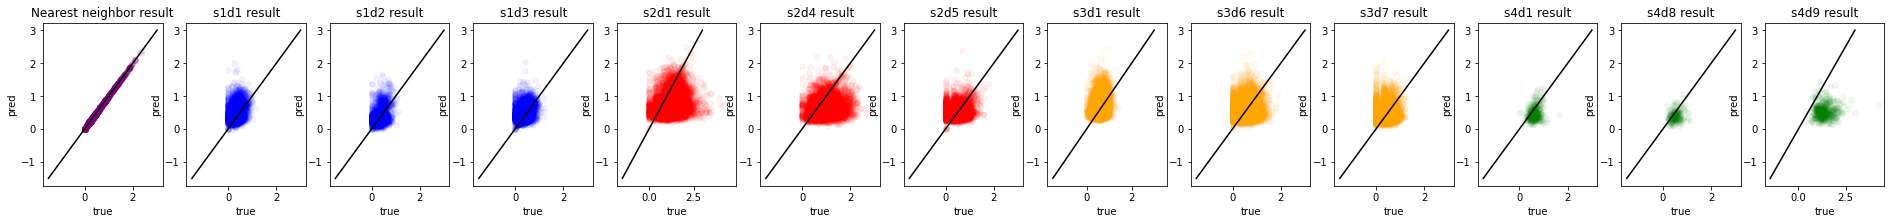

Epoch  7100 near loss: 0.0068866555 s1d1:  0.2820108 s1d2:  0.2173798 s1d3:  0.25085133 s2d1: 0.7193992 s2d4: 0.57192355 s2d5: 0.33309445 s3d1: 0.30636528 s3d6: 0.36549717 s3d7: 0.31893846 s4d1: 0.27701914 s4d8: 0.29195422 s4d9: 0.93903637 test loss: 0.6693403052306337
Epoch  7200 near loss: 0.0031637156 s1d1:  0.2869654 s1d2:  0.21989566 s1d3:  0.25483337 s2d1: 0.7167278 s2d4: 0.5696828 s2d5: 0.33469877 s3d1: 0.30905846 s3d6: 0.36705488 s3d7: 0.32089764 s4d1: 0.2764178 s4d8: 0.29126742 s4d9: 0.9348895 test loss: 0.6665249455802725
Epoch  7300 near loss: 0.0028883598 s1d1:  0.28643993 s1d2:  0.21966481 s1d3:  0.2543148 s2d1: 0.7167476 s2d4: 0.56953937 s2d5: 0.33456692 s3d1: 0.30884904 s3d6: 0.36681908 s3d7: 0.3209833 s4d1: 0.27613002 s4d8: 0.29089168 s4d9: 0.93494 test loss: 0.6664836445897082
Epoch  7400 near loss: 0.0041719386 s1d1:  0.28483453 s1d2:  0.21879847 s1d3:  0.25327256 s2d1: 0.7143931 s2d4: 0.567846 s2d5: 0.33625388 s3d1: 0.30717877 s3d6: 0.3660448 s3d7: 0.3212571 s4d1: 0.

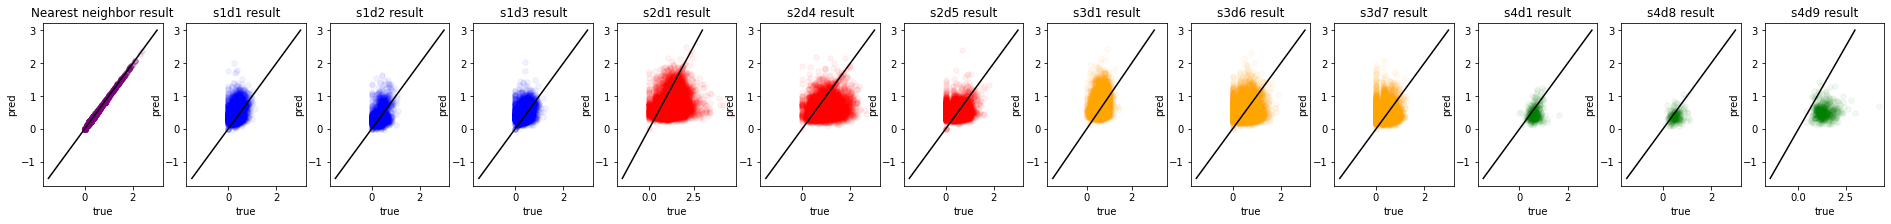

Epoch  8100 near loss: 0.0052013467 s1d1:  0.28562272 s1d2:  0.21917741 s1d3:  0.25367612 s2d1: 0.717034 s2d4: 0.5699237 s2d5: 0.3342603 s3d1: 0.30868688 s3d6: 0.3666303 s3d7: 0.32044086 s4d1: 0.27560627 s4d8: 0.290502 s4d9: 0.93480873 test loss: 0.6662915299819367
Epoch  8200 near loss: 0.0075794947 s1d1:  0.28432786 s1d2:  0.21856365 s1d3:  0.25251472 s2d1: 0.71938354 s2d4: 0.5718875 s2d5: 0.3329693 s3d1: 0.30696782 s3d6: 0.36599565 s3d7: 0.3189018 s4d1: 0.27637798 s4d8: 0.2915124 s4d9: 0.93718314 test loss: 0.6680184008287453
Epoch  8300 near loss: 0.0034614569 s1d1:  0.28816605 s1d2:  0.22058147 s1d3:  0.2561289 s2d1: 0.7139482 s2d4: 0.5678861 s2d5: 0.33624667 s3d1: 0.30991334 s3d6: 0.36743072 s3d7: 0.32214344 s4d1: 0.27414566 s4d8: 0.28977218 s4d9: 0.9300886 test loss: 0.6629842587240955
Epoch  8400 near loss: 0.0050895675 s1d1:  0.28629985 s1d2:  0.2196237 s1d3:  0.25464603 s2d1: 0.7161179 s2d4: 0.5694891 s2d5: 0.33477655 s3d1: 0.30850154 s3d6: 0.36652032 s3d7: 0.32081047 s4d1: 0

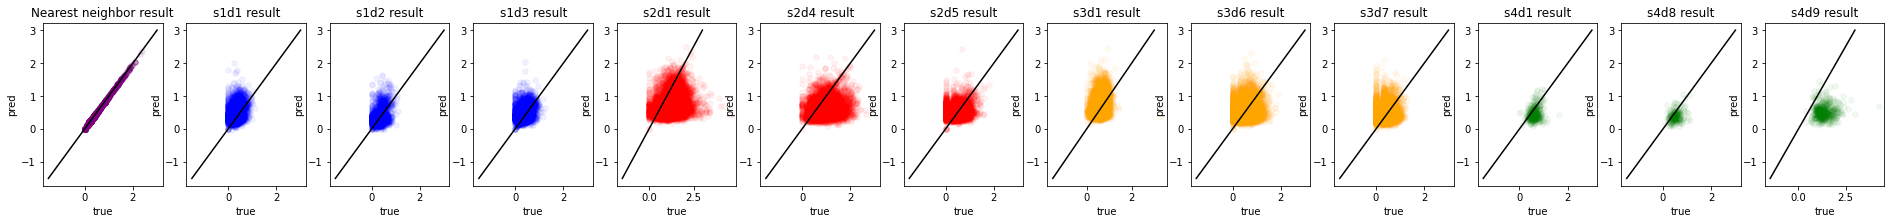

Epoch  9100 near loss: 0.004415792 s1d1:  0.28677872 s1d2:  0.22005683 s1d3:  0.25510454 s2d1: 0.71271324 s2d4: 0.5675941 s2d5: 0.33708304 s3d1: 0.30955073 s3d6: 0.36744818 s3d7: 0.32222205 s4d1: 0.27419114 s4d8: 0.29024413 s4d9: 0.9300725 test loss: 0.6630229157961745
Epoch  9200 near loss: 0.0055268244 s1d1:  0.28576344 s1d2:  0.2193656 s1d3:  0.254127 s2d1: 0.7169523 s2d4: 0.5705729 s2d5: 0.33429956 s3d1: 0.30855688 s3d6: 0.36662897 s3d7: 0.3201029 s4d1: 0.27562255 s4d8: 0.29129803 s4d9: 0.9351125 test loss: 0.6665612983782203
Epoch  9300 near loss: 0.004806427 s1d1:  0.28376716 s1d2:  0.2183173 s1d3:  0.25227728 s2d1: 0.7169354 s2d4: 0.5704539 s2d5: 0.3345707 s3d1: 0.30761024 s3d6: 0.36609697 s3d7: 0.31976283 s4d1: 0.27505255 s4d8: 0.2910469 s4d9: 0.9347116 test loss: 0.6662017440049727
Epoch  9400 near loss: 0.005614445 s1d1:  0.2842695 s1d2:  0.2186522 s1d3:  0.2530427 s2d1: 0.71685165 s2d4: 0.56991374 s2d5: 0.33437085 s3d1: 0.30748683 s3d6: 0.3662441 s3d7: 0.320075 s4d1: 0.27470

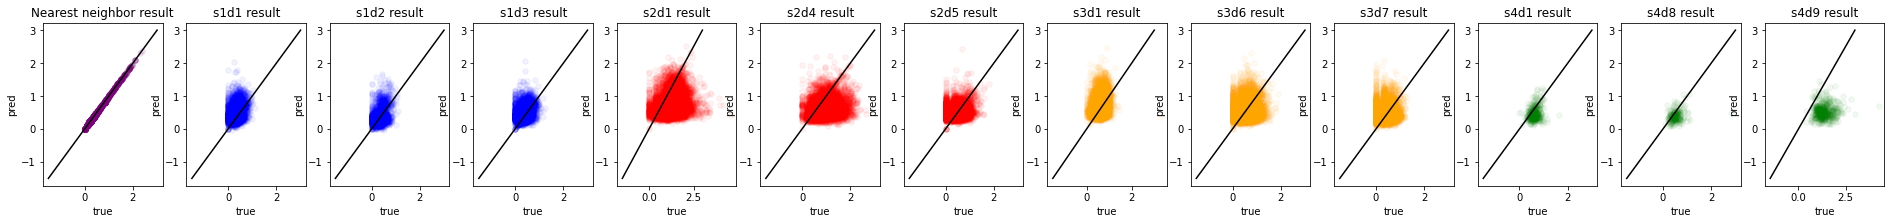

Epoch  10100 near loss: 0.0039505954 s1d1:  0.28498766 s1d2:  0.2192539 s1d3:  0.2540307 s2d1: 0.71549606 s2d4: 0.56957924 s2d5: 0.3353279 s3d1: 0.30801144 s3d6: 0.36643177 s3d7: 0.32032388 s4d1: 0.27474827 s4d8: 0.29102367 s4d9: 0.9327651 test loss: 0.6649042474104101
Epoch  10200 near loss: 0.0055466658 s1d1:  0.28746003 s1d2:  0.22013885 s1d3:  0.255929 s2d1: 0.71123016 s2d4: 0.5663176 s2d5: 0.337926 s3d1: 0.30912817 s3d6: 0.36742812 s3d7: 0.3224757 s4d1: 0.27258795 s4d8: 0.28906676 s4d9: 0.92642105 test loss: 0.6603437988233303
Epoch  10300 near loss: 0.0040663728 s1d1:  0.2842745 s1d2:  0.21881822 s1d3:  0.253377 s2d1: 0.7161309 s2d4: 0.5694199 s2d5: 0.33506355 s3d1: 0.307183 s3d6: 0.3660617 s3d7: 0.3198585 s4d1: 0.27414957 s4d8: 0.29052866 s4d9: 0.93257576 test loss: 0.6646549328675236
Epoch  10400 near loss: 0.0052480185 s1d1:  0.28534725 s1d2:  0.21947432 s1d3:  0.25414187 s2d1: 0.7173246 s2d4: 0.57098025 s2d5: 0.33407795 s3d1: 0.30782 s3d6: 0.36653554 s3d7: 0.319767 s4d1: 0.27

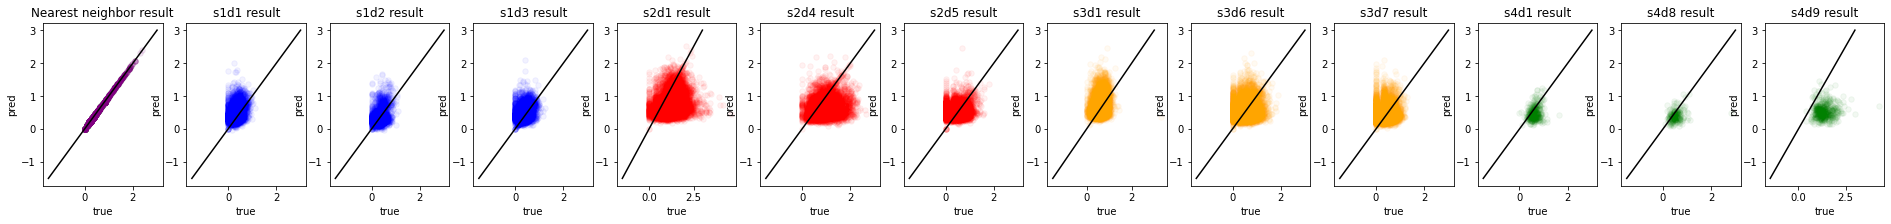

Epoch  11100 near loss: 0.0071903705 s1d1:  0.28896123 s1d2:  0.22092222 s1d3:  0.2569995 s2d1: 0.709672 s2d4: 0.5652573 s2d5: 0.33877444 s3d1: 0.3109566 s3d6: 0.3682364 s3d7: 0.32377422 s4d1: 0.27218646 s4d8: 0.28883487 s4d9: 0.9245687 test loss: 0.6590746277339484
Epoch  11200 near loss: 0.0053767 s1d1:  0.28972906 s1d2:  0.2214348 s1d3:  0.2575871 s2d1: 0.7106783 s2d4: 0.56605035 s2d5: 0.33805394 s3d1: 0.3107443 s3d6: 0.36836895 s3d7: 0.3233054 s4d1: 0.2731333 s4d8: 0.2895278 s4d9: 0.9259223 test loss: 0.6601397343211752
Epoch  11300 near loss: 0.01299712 s1d1:  0.28159085 s1d2:  0.21749963 s1d3:  0.2514693 s2d1: 0.72037745 s2d4: 0.57318795 s2d5: 0.33213723 s3d1: 0.3057912 s3d6: 0.36496857 s3d7: 0.3175516 s4d1: 0.27606165 s4d8: 0.29169086 s4d9: 0.9393726 test loss: 0.6694009568308907
Epoch  11400 near loss: 0.0040898058 s1d1:  0.2876168 s1d2:  0.2205346 s1d3:  0.25604415 s2d1: 0.7124915 s2d4: 0.5669232 s2d5: 0.33703476 s3d1: 0.30962148 s3d6: 0.367441 s3d7: 0.3220821 s4d1: 0.27311182

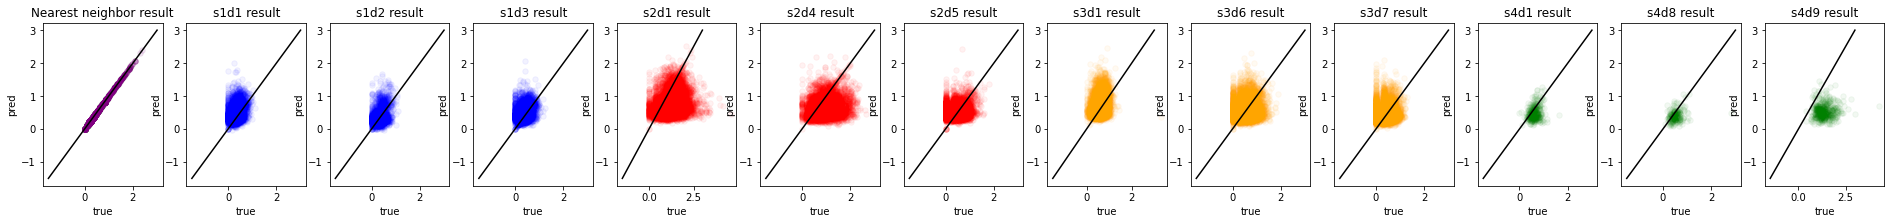

Epoch  12100 near loss: 0.00759391 s1d1:  0.2841895 s1d2:  0.21868055 s1d3:  0.25377664 s2d1: 0.71719533 s2d4: 0.5709085 s2d5: 0.33387172 s3d1: 0.30704322 s3d6: 0.3657939 s3d7: 0.319207 s4d1: 0.2750915 s4d8: 0.29099977 s4d9: 0.93451804 test loss: 0.6660782270850906
Epoch  12200 near loss: 0.0032647944 s1d1:  0.2869671 s1d2:  0.21988775 s1d3:  0.25588158 s2d1: 0.71335137 s2d4: 0.56772405 s2d5: 0.33632857 s3d1: 0.3084622 s3d6: 0.36683324 s3d7: 0.3213062 s4d1: 0.27284414 s4d8: 0.28910398 s4d9: 0.92828995 test loss: 0.6615860216198737
Epoch  12300 near loss: 0.0033417805 s1d1:  0.28608754 s1d2:  0.21960159 s1d3:  0.2553968 s2d1: 0.7142877 s2d4: 0.56831676 s2d5: 0.33604345 s3d1: 0.30752355 s3d6: 0.3663767 s3d7: 0.32071048 s4d1: 0.2732971 s4d8: 0.289579 s4d9: 0.9297009 test loss: 0.6626000863848027
Epoch  12400 near loss: 0.007525765 s1d1:  0.2901294 s1d2:  0.22173886 s1d3:  0.25872892 s2d1: 0.70873755 s2d4: 0.56442875 s2d5: 0.33913335 s3d1: 0.31053767 s3d6: 0.3682856 s3d7: 0.32377926 s4d1: 

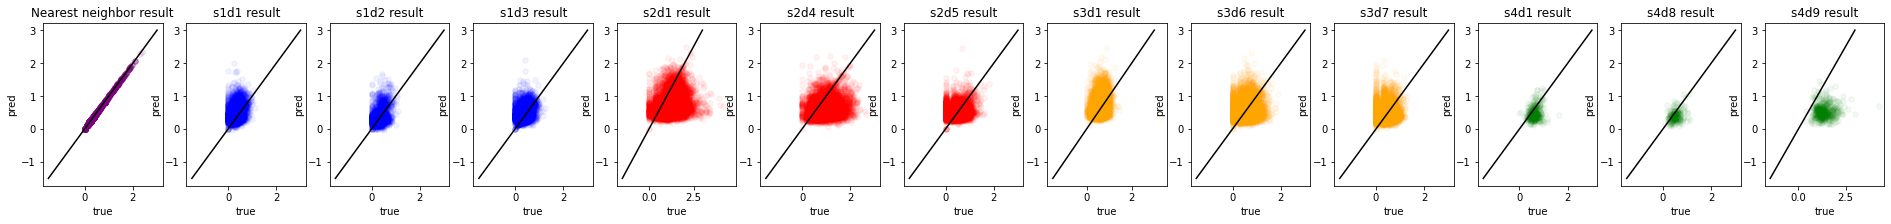

Epoch  13100 near loss: 0.0032770033 s1d1:  0.28663948 s1d2:  0.21993539 s1d3:  0.25603846 s2d1: 0.7135337 s2d4: 0.5681045 s2d5: 0.33596978 s3d1: 0.30821145 s3d6: 0.36666384 s3d7: 0.32096222 s4d1: 0.27329773 s4d8: 0.28918457 s4d9: 0.92941064 test loss: 0.6623775582257837
Epoch  13200 near loss: 0.0032995772 s1d1:  0.28818437 s1d2:  0.22063212 s1d3:  0.25706023 s2d1: 0.7113782 s2d4: 0.56633097 s2d5: 0.33739635 s3d1: 0.30949804 s3d6: 0.36737734 s3d7: 0.32224342 s4d1: 0.2721215 s4d8: 0.28846395 s4d9: 0.9259311 test loss: 0.6599093979565646
Epoch  13300 near loss: 0.0035315603 s1d1:  0.28664085 s1d2:  0.21981342 s1d3:  0.25589266 s2d1: 0.713207 s2d4: 0.56768614 s2d5: 0.33605194 s3d1: 0.30838925 s3d6: 0.36663762 s3d7: 0.32106915 s4d1: 0.27295527 s4d8: 0.28913608 s4d9: 0.9290272 test loss: 0.662079052818746
Epoch  13400 near loss: 0.0029226243 s1d1:  0.28611508 s1d2:  0.21967626 s1d3:  0.2555393 s2d1: 0.71315175 s2d4: 0.5674677 s2d5: 0.3363019 s3d1: 0.30803677 s3d6: 0.36653346 s3d7: 0.321089

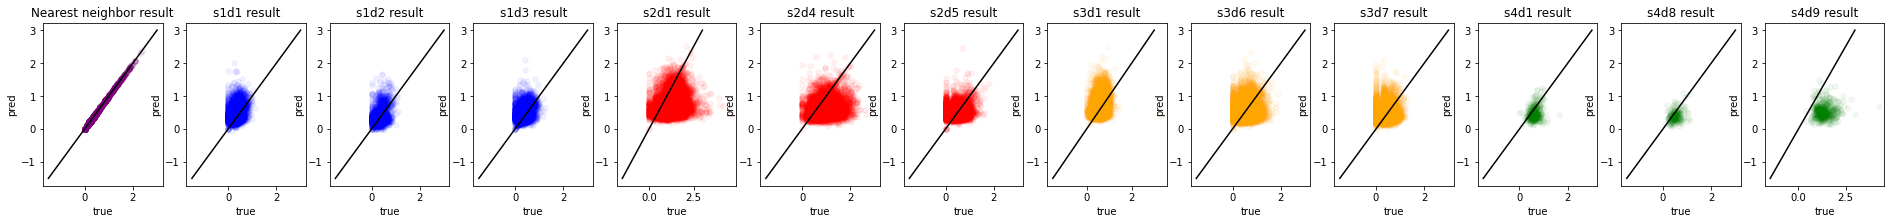

Epoch  14100 near loss: 0.0034934578 s1d1:  0.2882218 s1d2:  0.22063005 s1d3:  0.25750032 s2d1: 0.7114818 s2d4: 0.5666792 s2d5: 0.33743092 s3d1: 0.30833152 s3d6: 0.36717173 s3d7: 0.32159242 s4d1: 0.27240735 s4d8: 0.28867266 s4d9: 0.92563176 test loss: 0.6597749293344874
Epoch  14200 near loss: 0.0036485787 s1d1:  0.28907782 s1d2:  0.22120029 s1d3:  0.25813156 s2d1: 0.7117038 s2d4: 0.5660329 s2d5: 0.33684137 s3d1: 0.30957928 s3d6: 0.36715424 s3d7: 0.32219866 s4d1: 0.27200317 s4d8: 0.28810337 s4d9: 0.92590076 test loss: 0.6598409681060561
Epoch  14300 near loss: 0.0055943653 s1d1:  0.28976452 s1d2:  0.22150001 s1d3:  0.2586234 s2d1: 0.70984983 s2d4: 0.56516933 s2d5: 0.33835027 s3d1: 0.31007516 s3d6: 0.3681139 s3d7: 0.3230623 s4d1: 0.2721509 s4d8: 0.28862256 s4d9: 0.9233223 test loss: 0.658247949647327
Epoch  14400 near loss: 0.0035983545 s1d1:  0.28927335 s1d2:  0.22121762 s1d3:  0.2583226 s2d1: 0.71108216 s2d4: 0.5661389 s2d5: 0.3372845 s3d1: 0.30974185 s3d6: 0.3673875 s3d7: 0.32239 s4d

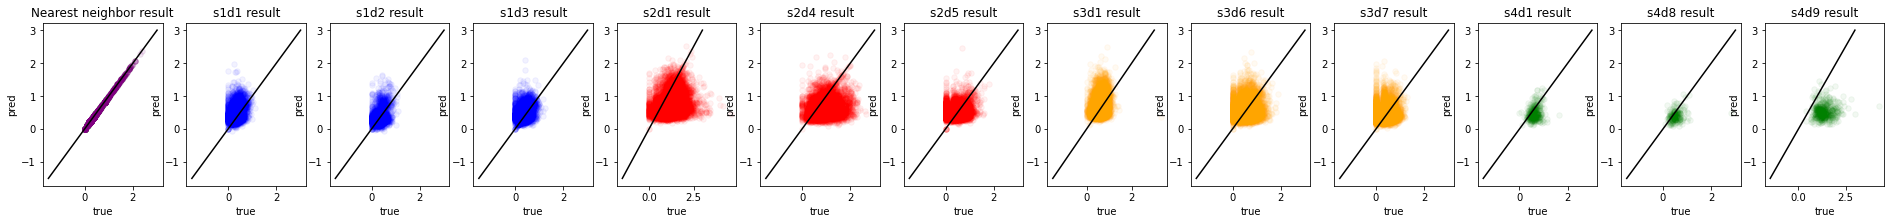

Epoch  15100 near loss: 0.0024043415 s1d1:  0.28810397 s1d2:  0.2206902 s1d3:  0.2574489 s2d1: 0.7118567 s2d4: 0.566963 s2d5: 0.33670375 s3d1: 0.30888748 s3d6: 0.36709842 s3d7: 0.32168502 s4d1: 0.27295727 s4d8: 0.28906432 s4d9: 0.9276563 test loss: 0.6611899351463599
Epoch  15200 near loss: 0.0032205975 s1d1:  0.28931877 s1d2:  0.22108492 s1d3:  0.25815138 s2d1: 0.71146655 s2d4: 0.56712645 s2d5: 0.3365095 s3d1: 0.30926403 s3d6: 0.3675683 s3d7: 0.3217234 s4d1: 0.27323815 s4d8: 0.28861317 s4d9: 0.9273549 test loss: 0.6609937978670312
Epoch  15300 near loss: 0.00321823 s1d1:  0.28873247 s1d2:  0.22080167 s1d3:  0.25784412 s2d1: 0.71186775 s2d4: 0.5669057 s2d5: 0.33653954 s3d1: 0.30857986 s3d6: 0.36713806 s3d7: 0.32141685 s4d1: 0.27224544 s4d8: 0.28806275 s4d9: 0.9272491 test loss: 0.6607391069528167
Epoch  15400 near loss: 0.008250099 s1d1:  0.29246023 s1d2:  0.22310007 s1d3:  0.2612376 s2d1: 0.707181 s2d4: 0.5637747 s2d5: 0.33965915 s3d1: 0.31143945 s3d6: 0.36869603 s3d7: 0.32447493 s4d1

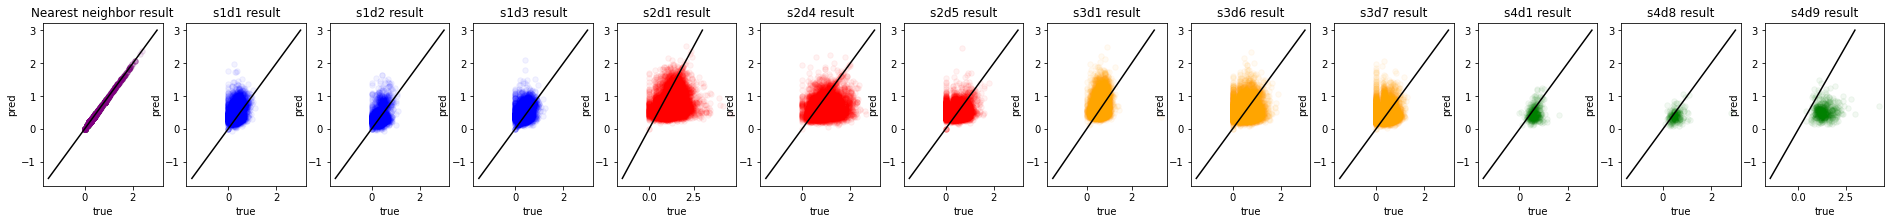

Epoch  16100 near loss: 0.0031423469 s1d1:  0.28815812 s1d2:  0.22084326 s1d3:  0.25783312 s2d1: 0.7120178 s2d4: 0.56694996 s2d5: 0.3366586 s3d1: 0.3079284 s3d6: 0.36669874 s3d7: 0.32140747 s4d1: 0.2728881 s4d8: 0.28837934 s4d9: 0.92728007 test loss: 0.6608761827453509
Epoch  16200 near loss: 0.0045445287 s1d1:  0.2874459 s1d2:  0.22033168 s1d3:  0.25722027 s2d1: 0.7126652 s2d4: 0.56770027 s2d5: 0.3359472 s3d1: 0.30745557 s3d6: 0.36629972 s3d7: 0.3206496 s4d1: 0.2730232 s4d8: 0.28868866 s4d9: 0.9287262 test loss: 0.6618541318102232
Epoch  16300 near loss: 0.0023529215 s1d1:  0.28885078 s1d2:  0.22119176 s1d3:  0.25833023 s2d1: 0.71130514 s2d4: 0.5664328 s2d5: 0.33694008 s3d1: 0.30863607 s3d6: 0.36706153 s3d7: 0.3219028 s4d1: 0.2724896 s4d8: 0.28834483 s4d9: 0.92644715 test loss: 0.6602817029310972
Epoch  16400 near loss: 0.006828753 s1d1:  0.2915032 s1d2:  0.22240254 s1d3:  0.2604846 s2d1: 0.70781165 s2d4: 0.5637836 s2d5: 0.33949903 s3d1: 0.30945265 s3d6: 0.3680461 s3d7: 0.32361138 s4d

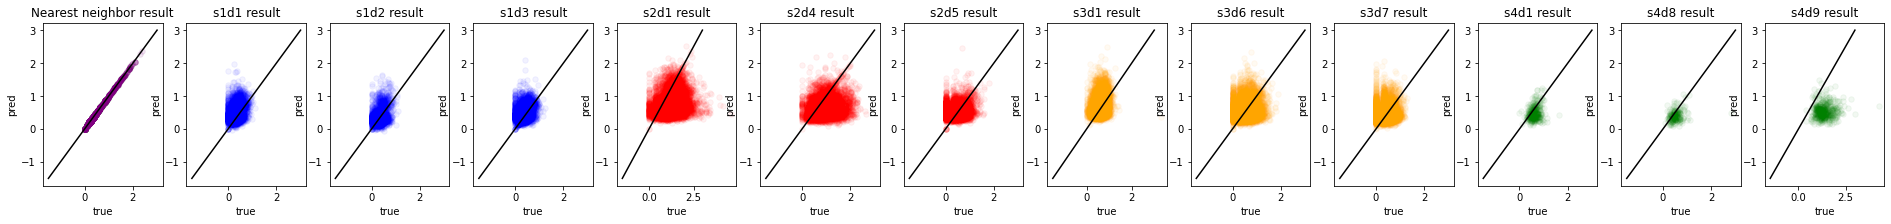

Epoch  17100 near loss: 0.004567984 s1d1:  0.29088327 s1d2:  0.22221196 s1d3:  0.26002747 s2d1: 0.70841914 s2d4: 0.5641435 s2d5: 0.33886123 s3d1: 0.30943102 s3d6: 0.36779955 s3d7: 0.3231486 s4d1: 0.27076858 s4d8: 0.28695056 s4d9: 0.9209231 test loss: 0.6563608440328063
Epoch  17200 near loss: 0.004190638 s1d1:  0.28798634 s1d2:  0.22075137 s1d3:  0.25766885 s2d1: 0.7122612 s2d4: 0.56696594 s2d5: 0.33626127 s3d1: 0.3070253 s3d6: 0.36641562 s3d7: 0.3209482 s4d1: 0.27243283 s4d8: 0.28843713 s4d9: 0.9269821 test loss: 0.6606267658052601
Epoch  17300 near loss: 0.0031672379 s1d1:  0.288162 s1d2:  0.22066803 s1d3:  0.2578844 s2d1: 0.711595 s2d4: 0.56629336 s2d5: 0.33664277 s3d1: 0.30719578 s3d6: 0.3664961 s3d7: 0.32117066 s4d1: 0.27190077 s4d8: 0.2876383 s4d9: 0.92584556 test loss: 0.6597493127779184
Epoch  17400 near loss: 0.007504894 s1d1:  0.2866164 s1d2:  0.22025095 s1d3:  0.2570602 s2d1: 0.7150698 s2d4: 0.56909394 s2d5: 0.33461565 s3d1: 0.3064454 s3d6: 0.3657832 s3d7: 0.3195427 s4d1: 0.

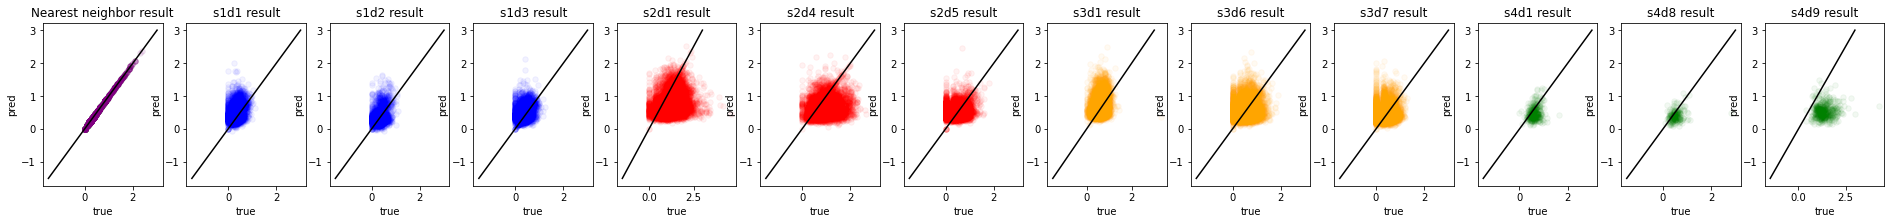

Epoch  18100 near loss: 0.0028015787 s1d1:  0.28830698 s1d2:  0.22104162 s1d3:  0.25823656 s2d1: 0.71054524 s2d4: 0.56521577 s2d5: 0.33732286 s3d1: 0.30814505 s3d6: 0.36671758 s3d7: 0.32189548 s4d1: 0.2712865 s4d8: 0.2873409 s4d9: 0.92393243 test loss: 0.6584056368614983
Epoch  18200 near loss: 0.015077523 s1d1:  0.28360423 s1d2:  0.21876374 s1d3:  0.25463158 s2d1: 0.71843815 s2d4: 0.5716351 s2d5: 0.33252913 s3d1: 0.3045163 s3d6: 0.36453083 s3d7: 0.31755877 s4d1: 0.27525508 s4d8: 0.29011565 s4d9: 0.9358986 test loss: 0.6669101525344412
Epoch  18300 near loss: 0.0026968129 s1d1:  0.28824162 s1d2:  0.22077765 s1d3:  0.25805584 s2d1: 0.71075547 s2d4: 0.566066 s2d5: 0.33722484 s3d1: 0.3081965 s3d6: 0.3670432 s3d7: 0.32162377 s4d1: 0.27209017 s4d8: 0.28786695 s4d9: 0.9251577 test loss: 0.6593530166608856
Epoch  18400 near loss: 0.0062268157 s1d1:  0.28705028 s1d2:  0.2204541 s1d3:  0.2574422 s2d1: 0.7141806 s2d4: 0.56843305 s2d5: 0.3353121 s3d1: 0.3070116 s3d6: 0.3660981 s3d7: 0.31992733 s4

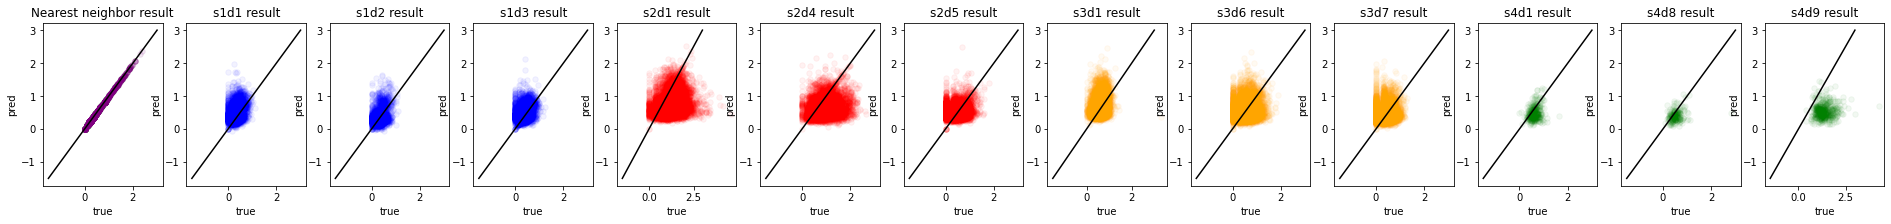

Epoch  19100 near loss: 0.0044016363 s1d1:  0.2890763 s1d2:  0.22139858 s1d3:  0.2589603 s2d1: 0.7127982 s2d4: 0.567079 s2d5: 0.33588475 s3d1: 0.30781212 s3d6: 0.3666127 s3d7: 0.320844 s4d1: 0.2728415 s4d8: 0.28834853 s4d9: 0.92726874 test loss: 0.6608596898443562
Epoch  19200 near loss: 0.006675975 s1d1:  0.28629524 s1d2:  0.22008468 s1d3:  0.25690418 s2d1: 0.7139434 s2d4: 0.5679441 s2d5: 0.33538887 s3d1: 0.3058943 s3d6: 0.36554524 s3d7: 0.31966886 s4d1: 0.2729797 s4d8: 0.2887798 s4d9: 0.92900896 test loss: 0.6620384937819219
Epoch  19300 near loss: 0.003913126 s1d1:  0.28931364 s1d2:  0.22149362 s1d3:  0.25927907 s2d1: 0.7096734 s2d4: 0.5643813 s2d5: 0.33795467 s3d1: 0.30821052 s3d6: 0.3670474 s3d7: 0.3221399 s4d1: 0.27091956 s4d8: 0.28705224 s4d9: 0.9220774 test loss: 0.6571342380345361
Epoch  19400 near loss: 0.0024662197 s1d1:  0.2895322 s1d2:  0.22159213 s1d3:  0.25954065 s2d1: 0.70968676 s2d4: 0.5647229 s2d5: 0.33801144 s3d1: 0.30814546 s3d6: 0.36695352 s3d7: 0.3221254 s4d1: 0.2

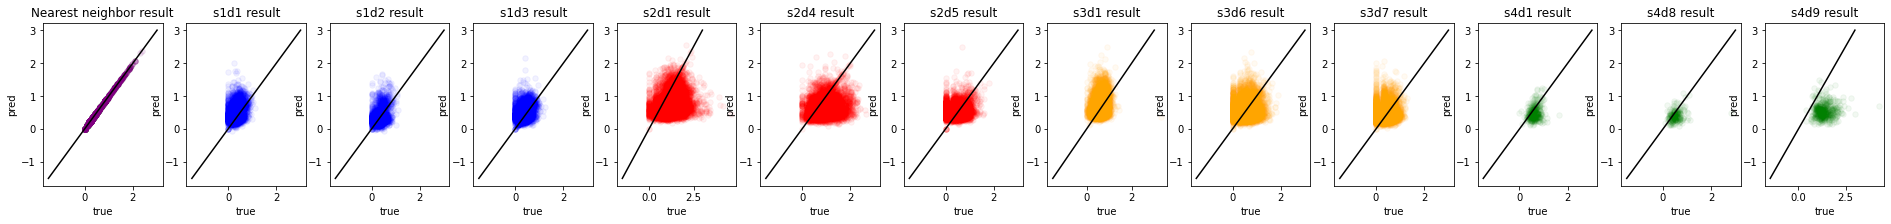

Epoch  20100 near loss: 0.0093089705 s1d1:  0.28643784 s1d2:  0.22025925 s1d3:  0.25732544 s2d1: 0.71503764 s2d4: 0.5691104 s2d5: 0.33458725 s3d1: 0.3060023 s3d6: 0.36536926 s3d7: 0.3192136 s4d1: 0.27409625 s4d8: 0.28936353 s4d9: 0.93087465 test loss: 0.663446720492032
Epoch  20200 near loss: 0.0052143754 s1d1:  0.29075533 s1d2:  0.22242145 s1d3:  0.26083443 s2d1: 0.70750624 s2d4: 0.56339633 s2d5: 0.33945376 s3d1: 0.30902097 s3d6: 0.36749068 s3d7: 0.32317784 s4d1: 0.27065966 s4d8: 0.28694353 s4d9: 0.9197628 test loss: 0.6555979606572843
Epoch  20300 near loss: 0.0036621364 s1d1:  0.29146215 s1d2:  0.22260317 s1d3:  0.261279 s2d1: 0.708116 s2d4: 0.5641554 s2d5: 0.33887526 s3d1: 0.30937812 s3d6: 0.36786547 s3d7: 0.3231829 s4d1: 0.27161646 s4d8: 0.28768393 s4d9: 0.9209003 test loss: 0.6565295691699484
Epoch  20400 near loss: 0.0031861048 s1d1:  0.29143775 s1d2:  0.22273013 s1d3:  0.26145148 s2d1: 0.7088622 s2d4: 0.5640924 s2d5: 0.33856246 s3d1: 0.308094 s3d6: 0.36715087 s3d7: 0.3224868 s4

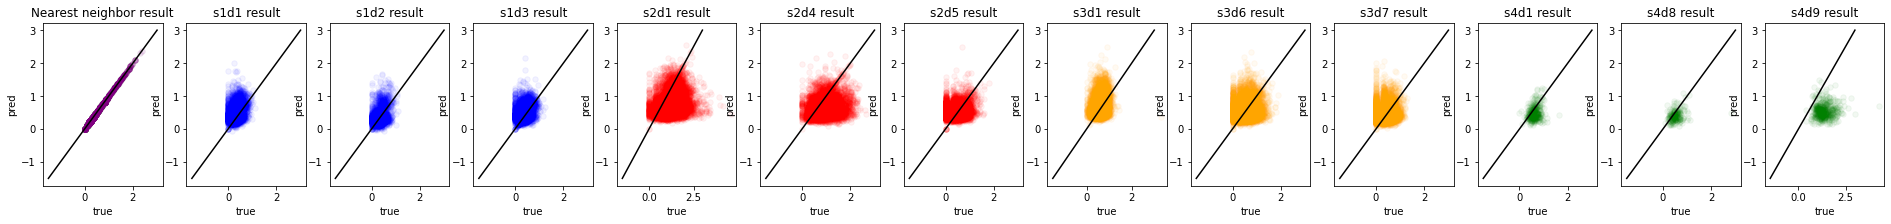

Epoch  21100 near loss: 0.003351371 s1d1:  0.28927052 s1d2:  0.22168496 s1d3:  0.25969443 s2d1: 0.70876753 s2d4: 0.5638003 s2d5: 0.33863375 s3d1: 0.30763707 s3d6: 0.36660638 s3d7: 0.3223337 s4d1: 0.2705496 s4d8: 0.28664473 s4d9: 0.92078143 test loss: 0.6562117605989314
Epoch  21200 near loss: 0.0062543503 s1d1:  0.28770664 s1d2:  0.2209478 s1d3:  0.25841776 s2d1: 0.71207184 s2d4: 0.5661805 s2d5: 0.33632457 s3d1: 0.30575427 s3d6: 0.36554936 s3d7: 0.3204988 s4d1: 0.27176988 s4d8: 0.28766975 s4d9: 0.92507154 test loss: 0.659235574786071
Epoch  21300 near loss: 0.0093752965 s1d1:  0.28522187 s1d2:  0.21972553 s1d3:  0.25649297 s2d1: 0.71497303 s2d4: 0.5686862 s2d5: 0.33463344 s3d1: 0.30522752 s3d6: 0.3647909 s3d7: 0.3189777 s4d1: 0.27295125 s4d8: 0.288318 s4d9: 0.9295151 test loss: 0.6623189448310076
Epoch  21400 near loss: 0.0026859595 s1d1:  0.2893962 s1d2:  0.22193874 s1d3:  0.2600509 s2d1: 0.7092149 s2d4: 0.5643618 s2d5: 0.33816087 s3d1: 0.30745828 s3d6: 0.36660096 s3d7: 0.32209575 s4d

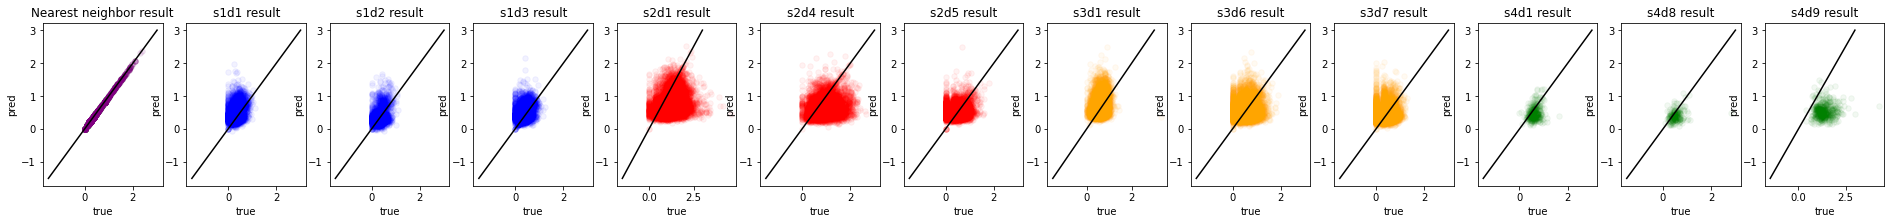

Epoch  22100 near loss: 0.003291631 s1d1:  0.28927132 s1d2:  0.22156647 s1d3:  0.2594955 s2d1: 0.71120083 s2d4: 0.5657764 s2d5: 0.33679816 s3d1: 0.30739737 s3d6: 0.36640796 s3d7: 0.32123226 s4d1: 0.271852 s4d8: 0.28753063 s4d9: 0.9241969 test loss: 0.6586709983271467
Epoch  22200 near loss: 0.0027220726 s1d1:  0.28856876 s1d2:  0.22114629 s1d3:  0.2588327 s2d1: 0.71100676 s2d4: 0.5658172 s2d5: 0.33708152 s3d1: 0.30738991 s3d6: 0.36637792 s3d7: 0.3212648 s4d1: 0.2718401 s4d8: 0.28774962 s4d9: 0.924709 test loss: 0.6590189829661054
Epoch  22300 near loss: 0.004126392 s1d1:  0.28826106 s1d2:  0.22118336 s1d3:  0.2588035 s2d1: 0.7115504 s2d4: 0.5660151 s2d5: 0.33651924 s3d1: 0.30663636 s3d6: 0.36604205 s3d7: 0.32078212 s4d1: 0.2719121 s4d8: 0.28791738 s4d9: 0.9246173 test loss: 0.6589849756336471
Epoch  22400 near loss: 0.004034477 s1d1:  0.28921983 s1d2:  0.22180681 s1d3:  0.2595075 s2d1: 0.71202797 s2d4: 0.56645364 s2d5: 0.33645815 s3d1: 0.30697346 s3d6: 0.36629215 s3d7: 0.32096198 s4d1:

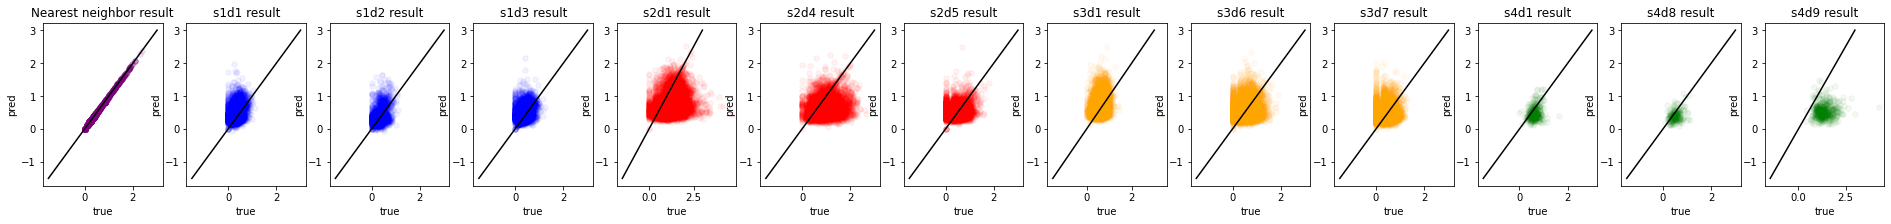

Epoch  23100 near loss: 0.0033198742 s1d1:  0.28843147 s1d2:  0.22125164 s1d3:  0.25909716 s2d1: 0.7093406 s2d4: 0.5643265 s2d5: 0.33812267 s3d1: 0.30693224 s3d6: 0.36632913 s3d7: 0.32180792 s4d1: 0.27097234 s4d8: 0.28696418 s4d9: 0.9217089 test loss: 0.6568961931370432
Epoch  23200 near loss: 0.0038183562 s1d1:  0.28778496 s1d2:  0.220968 s1d3:  0.25860444 s2d1: 0.7114732 s2d4: 0.5657306 s2d5: 0.3366171 s3d1: 0.30629468 s3d6: 0.3658811 s3d7: 0.32095245 s4d1: 0.2718592 s4d8: 0.28793278 s4d9: 0.92503047 test loss: 0.659245188774674
Epoch  23300 near loss: 0.002937301 s1d1:  0.29004708 s1d2:  0.22211637 s1d3:  0.2604011 s2d1: 0.70998263 s2d4: 0.5646634 s2d5: 0.33753908 s3d1: 0.30780497 s3d6: 0.36661676 s3d7: 0.32198024 s4d1: 0.27091345 s4d8: 0.2865371 s4d9: 0.9215278 test loss: 0.6567328555141793
Epoch  23400 near loss: 0.002796494 s1d1:  0.28955862 s1d2:  0.22183868 s1d3:  0.2602924 s2d1: 0.7084012 s2d4: 0.5639707 s2d5: 0.33871135 s3d1: 0.30786362 s3d6: 0.366706 s3d7: 0.3224701 s4d1: 0.

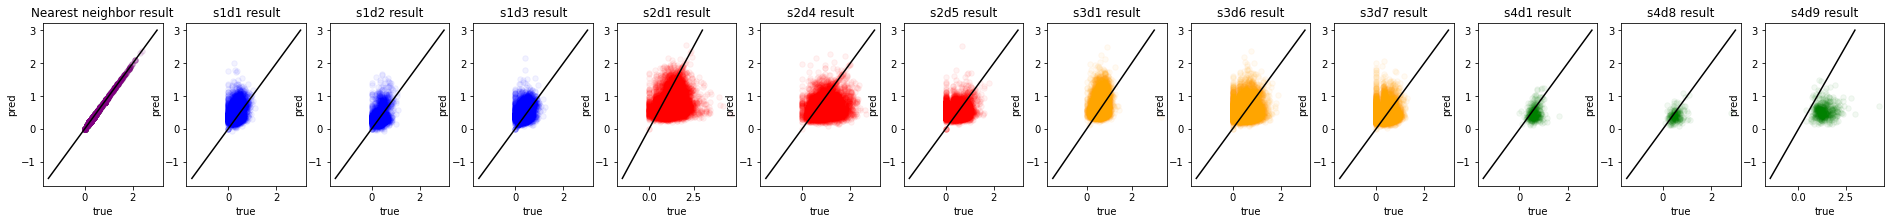

Epoch  24100 near loss: 0.003970432 s1d1:  0.28801578 s1d2:  0.22103442 s1d3:  0.25883377 s2d1: 0.7106592 s2d4: 0.56527627 s2d5: 0.33718854 s3d1: 0.30601203 s3d6: 0.36607224 s3d7: 0.3210823 s4d1: 0.27126575 s4d8: 0.28699982 s4d9: 0.9227198 test loss: 0.657590894986393
Epoch  24200 near loss: 0.00316405 s1d1:  0.29104376 s1d2:  0.222523 s1d3:  0.2612009 s2d1: 0.70975614 s2d4: 0.56480294 s2d5: 0.33743405 s3d1: 0.30863008 s3d6: 0.36722156 s3d7: 0.3222522 s4d1: 0.27176714 s4d8: 0.28691068 s4d9: 0.9222426 test loss: 0.6573446945539996
Epoch  24300 near loss: 0.0026252472 s1d1:  0.28987938 s1d2:  0.2219665 s1d3:  0.26009288 s2d1: 0.70865834 s2d4: 0.5635733 s2d5: 0.33835557 s3d1: 0.30749816 s3d6: 0.36677128 s3d7: 0.32239887 s4d1: 0.27035534 s4d8: 0.28648987 s4d9: 0.9198571 test loss: 0.6555756715971883
Epoch  24400 near loss: 0.004740405 s1d1:  0.29199564 s1d2:  0.22322105 s1d3:  0.2620416 s2d1: 0.7061973 s2d4: 0.5623632 s2d5: 0.3400163 s3d1: 0.309223 s3d6: 0.36790276 s3d7: 0.3238348 s4d1: 0.

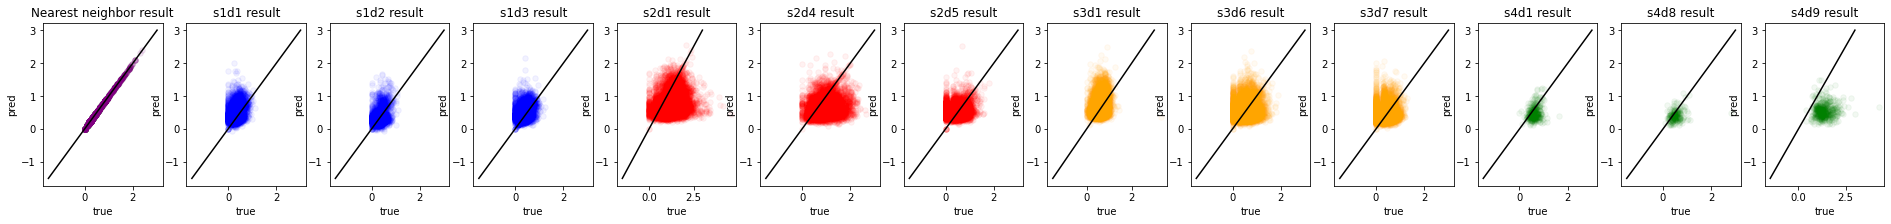

Epoch  25100 near loss: 0.007096985 s1d1:  0.287359 s1d2:  0.22077909 s1d3:  0.25825918 s2d1: 0.71281683 s2d4: 0.5663458 s2d5: 0.335511 s3d1: 0.30524328 s3d6: 0.36552924 s3d7: 0.32017666 s4d1: 0.27153894 s4d8: 0.28698477 s4d9: 0.9244865 test loss: 0.6587651234486405
Epoch  25200 near loss: 0.0041812435 s1d1:  0.28807518 s1d2:  0.22115782 s1d3:  0.25884378 s2d1: 0.7116684 s2d4: 0.5660197 s2d5: 0.336437 s3d1: 0.30629689 s3d6: 0.36600265 s3d7: 0.32067823 s4d1: 0.27180046 s4d8: 0.28727198 s4d9: 0.9243431 test loss: 0.658734692332581
Epoch  25300 near loss: 0.003400812 s1d1:  0.28970304 s1d2:  0.22202487 s1d3:  0.2601645 s2d1: 0.7105553 s2d4: 0.5651707 s2d5: 0.33708048 s3d1: 0.30692482 s3d6: 0.36647847 s3d7: 0.32134655 s4d1: 0.2714375 s4d8: 0.28672695 s4d9: 0.9222064 test loss: 0.657259296605323
Epoch  25400 near loss: 0.0043890816 s1d1:  0.29090476 s1d2:  0.22281723 s1d3:  0.26173836 s2d1: 0.7070666 s2d4: 0.5622167 s2d5: 0.33938178 s3d1: 0.30763784 s3d6: 0.36706093 s3d7: 0.3231587 s4d1: 0.

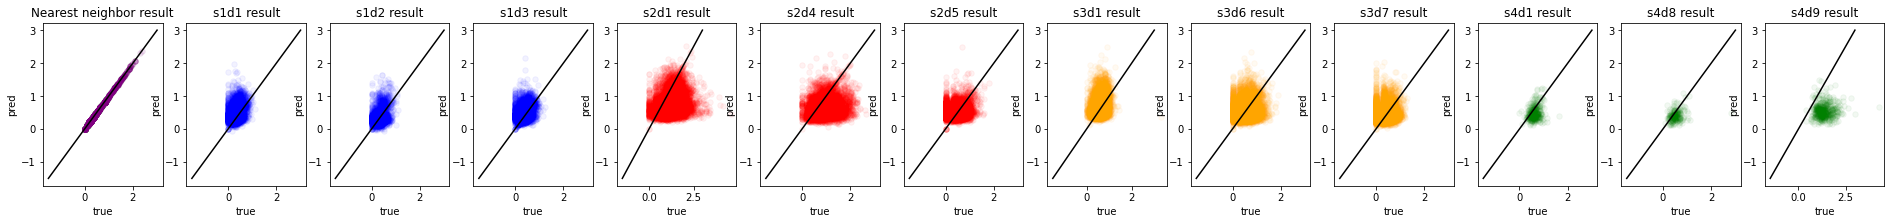

Epoch  26100 near loss: 0.0056547164 s1d1:  0.2916581 s1d2:  0.22307204 s1d3:  0.26205766 s2d1: 0.70679045 s2d4: 0.5616154 s2d5: 0.33965093 s3d1: 0.30890635 s3d6: 0.36752722 s3d7: 0.32385907 s4d1: 0.26900205 s4d8: 0.2847108 s4d9: 0.9157708 test loss: 0.652596687328962
Epoch  26200 near loss: 0.004738058 s1d1:  0.29057935 s1d2:  0.2223934 s1d3:  0.26099098 s2d1: 0.70694053 s2d4: 0.56203985 s2d5: 0.33936548 s3d1: 0.30820972 s3d6: 0.3673034 s3d7: 0.323508 s4d1: 0.26955554 s4d8: 0.28557584 s4d9: 0.9165607 test loss: 0.6532598507819928
Epoch  26300 near loss: 0.0027705242 s1d1:  0.28911895 s1d2:  0.22171396 s1d3:  0.25986794 s2d1: 0.7091273 s2d4: 0.5638637 s2d5: 0.33816832 s3d1: 0.30687132 s3d6: 0.36640054 s3d7: 0.32189137 s4d1: 0.27023372 s4d8: 0.28626132 s4d9: 0.9200542 test loss: 0.6556652200272166
Epoch  26400 near loss: 0.0022855052 s1d1:  0.28965053 s1d2:  0.22210151 s1d3:  0.2604067 s2d1: 0.7090646 s2d4: 0.5641521 s2d5: 0.3381638 s3d1: 0.3077941 s3d6: 0.36675617 s3d7: 0.32214344 s4d1

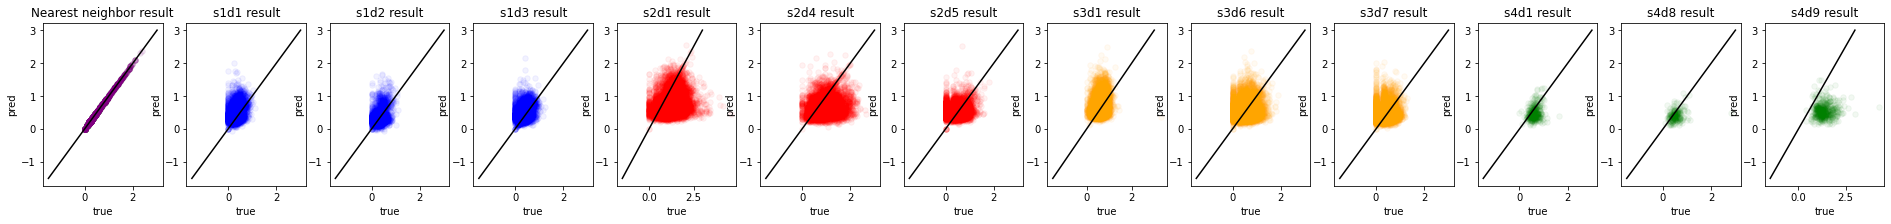

Epoch  27100 near loss: 0.0034419808 s1d1:  0.2881762 s1d2:  0.22149546 s1d3:  0.25925118 s2d1: 0.7104097 s2d4: 0.56488425 s2d5: 0.33710548 s3d1: 0.305986 s3d6: 0.36604884 s3d7: 0.32116082 s4d1: 0.2707313 s4d8: 0.28608525 s4d9: 0.9211787 test loss: 0.656442114950767
Epoch  27200 near loss: 0.002689551 s1d1:  0.29048273 s1d2:  0.22254342 s1d3:  0.26094452 s2d1: 0.7082157 s2d4: 0.5634916 s2d5: 0.3383988 s3d1: 0.30814433 s3d6: 0.36706865 s3d7: 0.3226672 s4d1: 0.27015024 s4d8: 0.28569824 s4d9: 0.91872364 test loss: 0.6547458759220219
Epoch  27300 near loss: 0.0028332458 s1d1:  0.28831106 s1d2:  0.22139095 s1d3:  0.25937122 s2d1: 0.7092916 s2d4: 0.5641237 s2d5: 0.33791223 s3d1: 0.30690745 s3d6: 0.36642823 s3d7: 0.32190865 s4d1: 0.27083105 s4d8: 0.2866688 s4d9: 0.9207384 test loss: 0.6562249903170775
Epoch  27400 near loss: 0.0018215595 s1d1:  0.28893307 s1d2:  0.22179854 s1d3:  0.25986823 s2d1: 0.7093036 s2d4: 0.56423783 s2d5: 0.3379261 s3d1: 0.30753377 s3d6: 0.3667993 s3d7: 0.32209092 s4d1

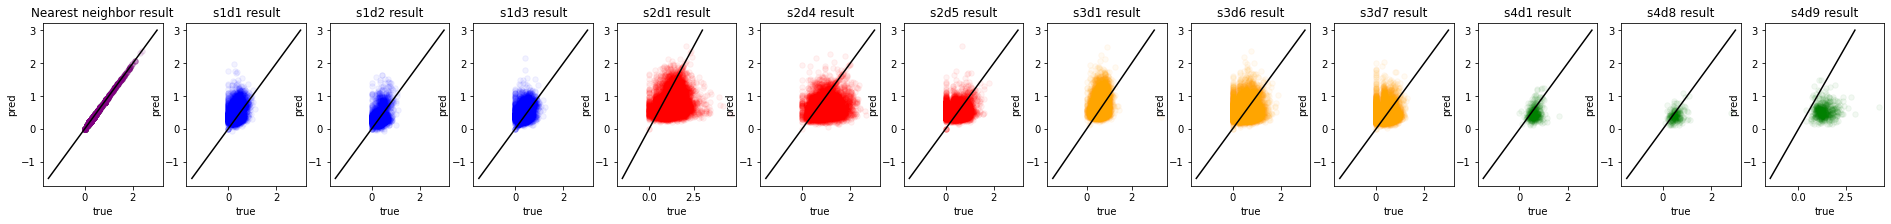

Epoch  28100 near loss: 0.0023537534 s1d1:  0.29000026 s1d2:  0.22241984 s1d3:  0.26077175 s2d1: 0.7080871 s2d4: 0.5637287 s2d5: 0.3386152 s3d1: 0.3083159 s3d6: 0.36725464 s3d7: 0.32270768 s4d1: 0.27097583 s4d8: 0.2863104 s4d9: 0.9195234 test loss: 0.6554301320260965
Epoch  28200 near loss: 0.0077173905 s1d1:  0.28687924 s1d2:  0.22077179 s1d3:  0.25847566 s2d1: 0.71182936 s2d4: 0.5662457 s2d5: 0.33633348 s3d1: 0.30522808 s3d6: 0.36542302 s3d7: 0.32024625 s4d1: 0.2713937 s4d8: 0.28655678 s4d9: 0.9238846 test loss: 0.6583188130617368
Epoch  28300 near loss: 0.008081553 s1d1:  0.28658468 s1d2:  0.22071053 s1d3:  0.25809923 s2d1: 0.71279866 s2d4: 0.5664659 s2d5: 0.3355531 s3d1: 0.30499694 s3d6: 0.36519822 s3d7: 0.3198631 s4d1: 0.27147415 s4d8: 0.28646287 s4d9: 0.9242889 test loss: 0.6585819103719829
Epoch  28400 near loss: 0.0025434275 s1d1:  0.28989542 s1d2:  0.22238038 s1d3:  0.2607627 s2d1: 0.7089031 s2d4: 0.56374156 s2d5: 0.33806613 s3d1: 0.30697268 s3d6: 0.3666135 s3d7: 0.32216427 s4

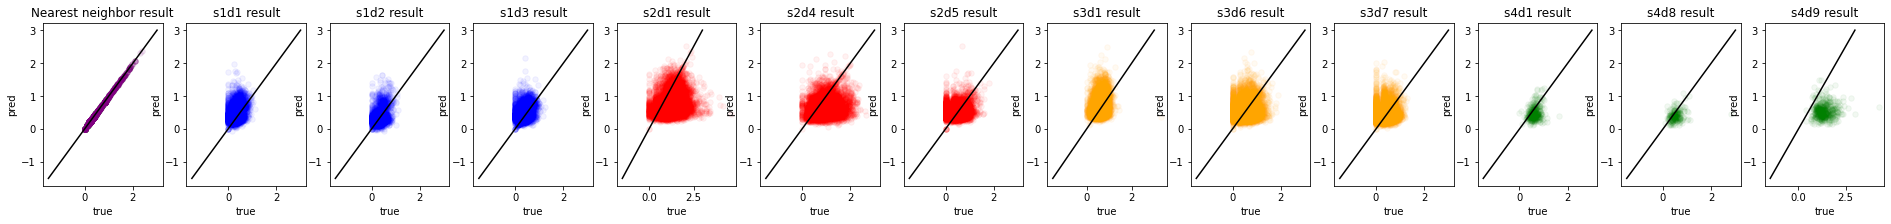

Epoch  29100 near loss: 0.0022840675 s1d1:  0.2905131 s1d2:  0.22258711 s1d3:  0.2611645 s2d1: 0.7081738 s2d4: 0.56348 s2d5: 0.33845308 s3d1: 0.30813265 s3d6: 0.3671224 s3d7: 0.3226501 s4d1: 0.27061224 s4d8: 0.28602216 s4d9: 0.9186443 test loss: 0.6547877667038645
Epoch  29200 near loss: 0.0029488085 s1d1:  0.28976542 s1d2:  0.22219166 s1d3:  0.26063278 s2d1: 0.70997876 s2d4: 0.56443185 s2d5: 0.3373015 s3d1: 0.30715892 s3d6: 0.3667032 s3d7: 0.32177898 s4d1: 0.27108487 s4d8: 0.28644466 s4d9: 0.9207871 test loss: 0.6562711061762057
Epoch  29300 near loss: 0.0020468216 s1d1:  0.28990456 s1d2:  0.2223751 s1d3:  0.2607881 s2d1: 0.7084331 s2d4: 0.5633943 s2d5: 0.3383115 s3d1: 0.30726966 s3d6: 0.36677277 s3d7: 0.32248878 s4d1: 0.27051303 s4d8: 0.28609052 s4d9: 0.91886646 test loss: 0.6549233278255919
Epoch  29400 near loss: 0.0033434555 s1d1:  0.28926024 s1d2:  0.22207306 s1d3:  0.2603035 s2d1: 0.70976293 s2d4: 0.56420875 s2d5: 0.33749595 s3d1: 0.3066023 s3d6: 0.36623892 s3d7: 0.32164946 s4d1

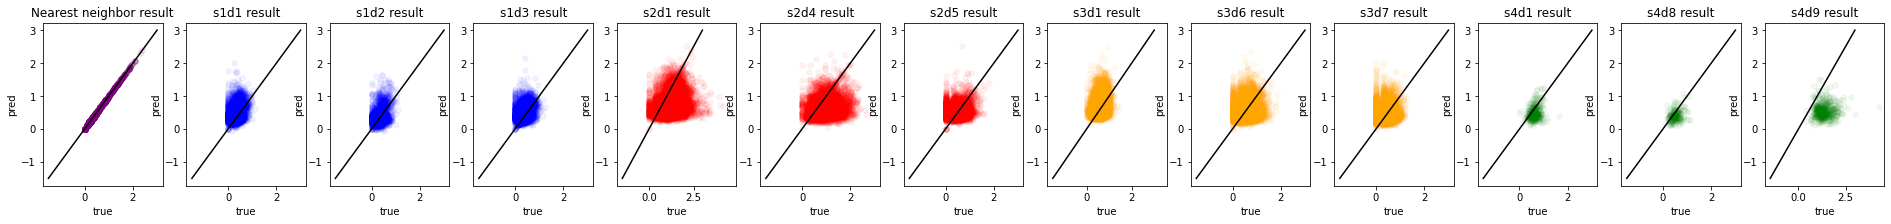

Epoch  30100 near loss: 0.004460196 s1d1:  0.29139528 s1d2:  0.22300449 s1d3:  0.26210022 s2d1: 0.70579314 s2d4: 0.56188434 s2d5: 0.3400872 s3d1: 0.30882207 s3d6: 0.36775872 s3d7: 0.32372323 s4d1: 0.26984435 s4d8: 0.28548273 s4d9: 0.91537213 test loss: 0.6525258821539577
Epoch  30200 near loss: 0.0065390677 s1d1:  0.28771198 s1d2:  0.22140244 s1d3:  0.25917116 s2d1: 0.7118202 s2d4: 0.5658921 s2d5: 0.336249 s3d1: 0.30565876 s3d6: 0.36566645 s3d7: 0.32039574 s4d1: 0.2717176 s4d8: 0.28669193 s4d9: 0.92298 test loss: 0.6577930153806203
Epoch  30300 near loss: 0.006085944 s1d1:  0.28798983 s1d2:  0.22147538 s1d3:  0.25935814 s2d1: 0.71163183 s2d4: 0.5660602 s2d5: 0.3362362 s3d1: 0.30602396 s3d6: 0.36602554 s3d7: 0.32065526 s4d1: 0.27243224 s4d8: 0.28739753 s4d9: 0.92397255 test loss: 0.6585945614598209
Epoch  30400 near loss: 0.0026397435 s1d1:  0.2891346 s1d2:  0.22182937 s1d3:  0.26022583 s2d1: 0.7083472 s2d4: 0.5632734 s2d5: 0.3383353 s3d1: 0.30671865 s3d6: 0.3667802 s3d7: 0.32222334 s4d

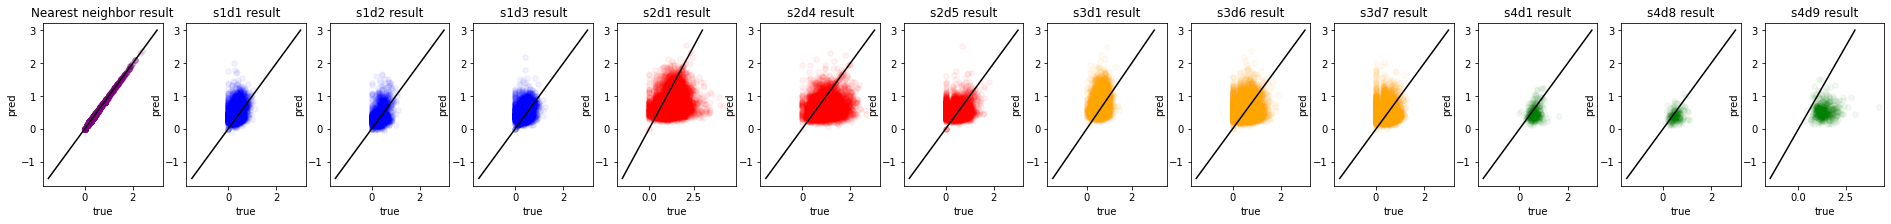

Epoch  31100 near loss: 0.0027173173 s1d1:  0.28969982 s1d2:  0.22250953 s1d3:  0.26097432 s2d1: 0.7073421 s2d4: 0.5627454 s2d5: 0.33906394 s3d1: 0.3072365 s3d6: 0.36685106 s3d7: 0.32273015 s4d1: 0.26997632 s4d8: 0.285841 s4d9: 0.91702914 test loss: 0.6536435263917242
Epoch  31200 near loss: 0.002839162 s1d1:  0.2893689 s1d2:  0.22226062 s1d3:  0.26051348 s2d1: 0.70915294 s2d4: 0.5641395 s2d5: 0.3376194 s3d1: 0.3076192 s3d6: 0.3668532 s3d7: 0.32192895 s4d1: 0.27094388 s4d8: 0.28658652 s4d9: 0.9198273 test loss: 0.6556463677930794
Epoch  31300 near loss: 0.002819324 s1d1:  0.29158452 s1d2:  0.22341871 s1d3:  0.26229057 s2d1: 0.7072728 s2d4: 0.56284064 s2d5: 0.33871943 s3d1: 0.3084063 s3d6: 0.3675769 s3d7: 0.32326564 s4d1: 0.2703547 s4d8: 0.28580824 s4d9: 0.91719663 test loss: 0.6538006378213966
Epoch  31400 near loss: 0.00544515 s1d1:  0.28823677 s1d2:  0.22174859 s1d3:  0.25964832 s2d1: 0.7099069 s2d4: 0.56463826 s2d5: 0.33710122 s3d1: 0.3061681 s3d6: 0.3661937 s3d7: 0.32125723 s4d1: 0

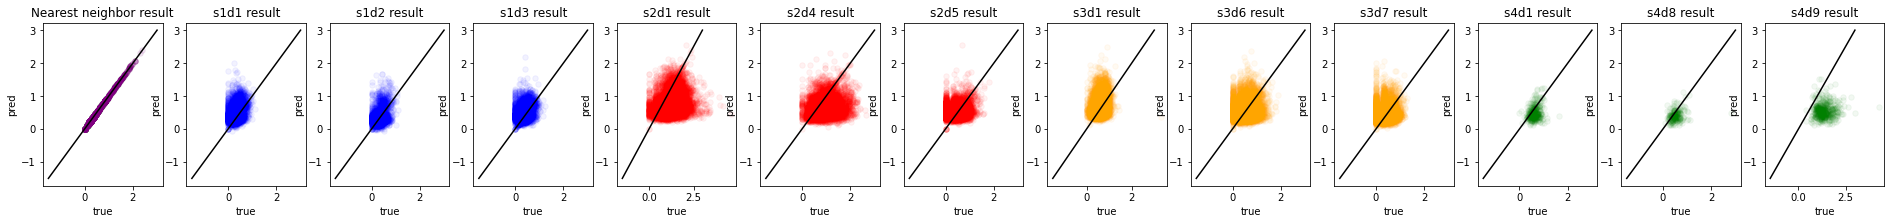

Epoch  32100 near loss: 0.0020642602 s1d1:  0.29006955 s1d2:  0.22269037 s1d3:  0.2614091 s2d1: 0.7080236 s2d4: 0.5630866 s2d5: 0.3383541 s3d1: 0.3074101 s3d6: 0.36697432 s3d7: 0.3225582 s4d1: 0.27029225 s4d8: 0.28593484 s4d9: 0.9177182 test loss: 0.6541393222258263
Epoch  32200 near loss: 0.0029484236 s1d1:  0.29006988 s1d2:  0.22275874 s1d3:  0.2612148 s2d1: 0.7099166 s2d4: 0.56429267 s2d5: 0.337142 s3d1: 0.30731347 s3d6: 0.36690712 s3d7: 0.32186314 s4d1: 0.2710366 s4d8: 0.28640774 s4d9: 0.9199748 test loss: 0.6557380026237654
Epoch  32300 near loss: 0.004738782 s1d1:  0.28912553 s1d2:  0.22234261 s1d3:  0.26050198 s2d1: 0.71017265 s2d4: 0.5649078 s2d5: 0.3369648 s3d1: 0.30678165 s3d6: 0.3663473 s3d7: 0.3213709 s4d1: 0.27091232 s4d8: 0.28647745 s4d9: 0.92091924 test loss: 0.6563353732469073
Epoch  32400 near loss: 0.004676815 s1d1:  0.28790987 s1d2:  0.22140436 s1d3:  0.25924549 s2d1: 0.70997846 s2d4: 0.5642838 s2d5: 0.33705026 s3d1: 0.3056382 s3d6: 0.36611226 s3d7: 0.32139692 s4d1: 

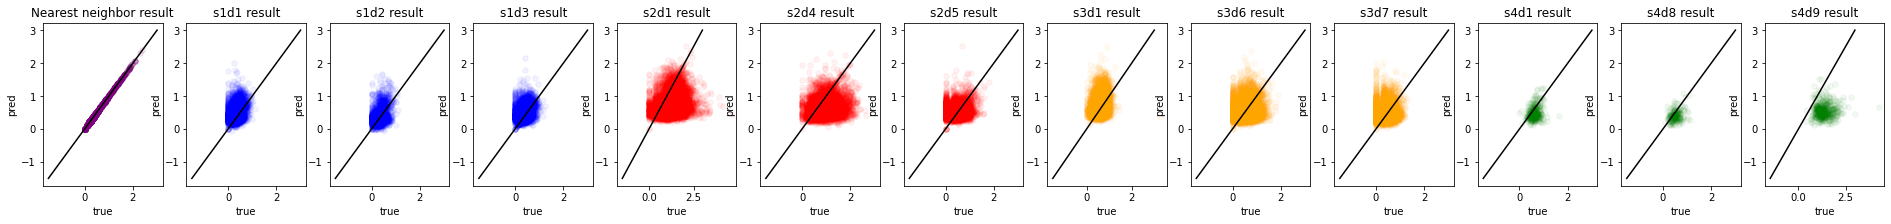

Epoch  33100 near loss: 0.0030296124 s1d1:  0.2889989 s1d2:  0.22213192 s1d3:  0.26032686 s2d1: 0.7092011 s2d4: 0.56384385 s2d5: 0.33728918 s3d1: 0.30663097 s3d6: 0.36653015 s3d7: 0.3219766 s4d1: 0.27031532 s4d8: 0.28595784 s4d9: 0.9194398 test loss: 0.655253304395354
Epoch  33200 near loss: 0.0023197213 s1d1:  0.290653 s1d2:  0.22301754 s1d3:  0.26203236 s2d1: 0.7071713 s2d4: 0.5626026 s2d5: 0.33885214 s3d1: 0.3071479 s3d6: 0.36719182 s3d7: 0.32298005 s4d1: 0.2700107 s4d8: 0.28550804 s4d9: 0.9161141 test loss: 0.6530289126971043
Epoch  33300 near loss: 0.0039554527 s1d1:  0.2894507 s1d2:  0.222552 s1d3:  0.2608515 s2d1: 0.709017 s2d4: 0.5637371 s2d5: 0.33750093 s3d1: 0.30638286 s3d6: 0.366494 s3d7: 0.3219734 s4d1: 0.2703133 s4d8: 0.2859212 s4d9: 0.91858673 test loss: 0.6547003082499664
Epoch  33400 near loss: 0.0025508387 s1d1:  0.28865537 s1d2:  0.22195134 s1d3:  0.26011103 s2d1: 0.7076449 s2d4: 0.5627426 s2d5: 0.338495 s3d1: 0.30622137 s3d6: 0.3665713 s3d7: 0.32245725 s4d1: 0.269413

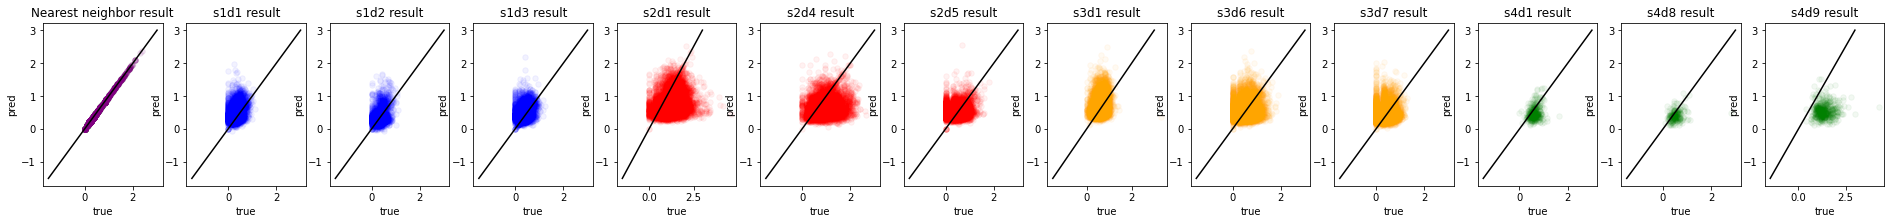

Epoch  34100 near loss: 0.0032785025 s1d1:  0.28865528 s1d2:  0.22208694 s1d3:  0.26015577 s2d1: 0.7094331 s2d4: 0.5646329 s2d5: 0.33748433 s3d1: 0.3063779 s3d6: 0.36657003 s3d7: 0.32153282 s4d1: 0.27087575 s4d8: 0.2866578 s4d9: 0.92028224 test loss: 0.6559364061348741
Epoch  34200 near loss: 0.0023275744 s1d1:  0.28898603 s1d2:  0.22224274 s1d3:  0.2604689 s2d1: 0.70818776 s2d4: 0.56343406 s2d5: 0.33811036 s3d1: 0.3061033 s3d6: 0.36660764 s3d7: 0.32205737 s4d1: 0.2699666 s4d8: 0.28582248 s4d9: 0.9176061 test loss: 0.6540120624570793
Epoch  34300 near loss: 0.0021947557 s1d1:  0.29083 s1d2:  0.22325346 s1d3:  0.26206848 s2d1: 0.7073456 s2d4: 0.56314 s2d5: 0.33880374 s3d1: 0.3075198 s3d6: 0.36753732 s3d7: 0.32288125 s4d1: 0.2705423 s4d8: 0.2860949 s4d9: 0.91715074 test loss: 0.6538229689381676
Epoch  34400 near loss: 0.0026682315 s1d1:  0.29039058 s1d2:  0.22296028 s1d3:  0.26178995 s2d1: 0.70776576 s2d4: 0.5631841 s2d5: 0.3382682 s3d1: 0.30724823 s3d6: 0.3670449 s3d7: 0.32256854 s4d1: 

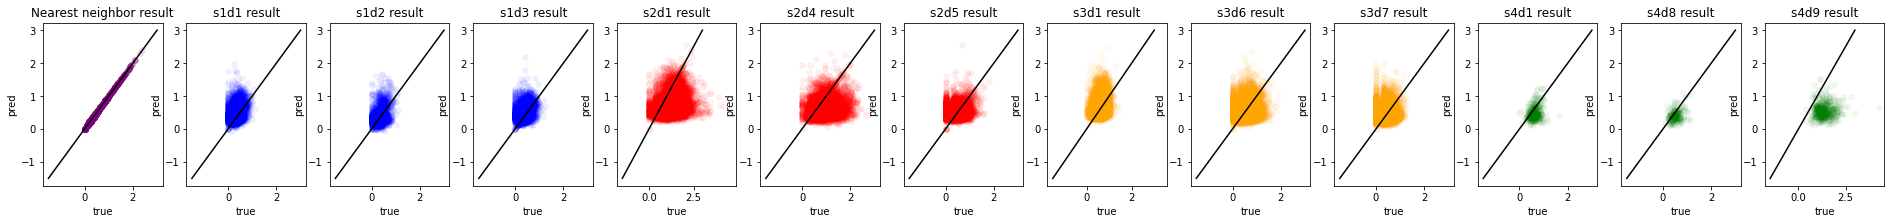

Epoch  35100 near loss: 0.0042954977 s1d1:  0.28949463 s1d2:  0.22247857 s1d3:  0.2609725 s2d1: 0.70910984 s2d4: 0.56379545 s2d5: 0.33714256 s3d1: 0.3059895 s3d6: 0.36644372 s3d7: 0.32159168 s4d1: 0.27005196 s4d8: 0.2856673 s4d9: 0.91828036 test loss: 0.6544440358138579
Epoch  35200 near loss: 0.0061208014 s1d1:  0.29313228 s1d2:  0.22439435 s1d3:  0.26415482 s2d1: 0.70430577 s2d4: 0.56057405 s2d5: 0.34051582 s3d1: 0.3084597 s3d6: 0.3682538 s3d7: 0.3245478 s4d1: 0.26873556 s4d8: 0.28489432 s4d9: 0.9121044 test loss: 0.6502154464274291
Epoch  35300 near loss: 0.0034631076 s1d1:  0.28889117 s1d2:  0.2221193 s1d3:  0.26027092 s2d1: 0.708481 s2d4: 0.56387615 s2d5: 0.3376366 s3d1: 0.30627692 s3d6: 0.36655876 s3d7: 0.32191294 s4d1: 0.2699179 s4d8: 0.28566176 s4d9: 0.9182352 test loss: 0.6543959670968322
Epoch  35400 near loss: 0.0020990903 s1d1:  0.29076114 s1d2:  0.22321723 s1d3:  0.2620509 s2d1: 0.70649284 s2d4: 0.5626205 s2d5: 0.33902115 s3d1: 0.30701274 s3d6: 0.36739695 s3d7: 0.32303867 

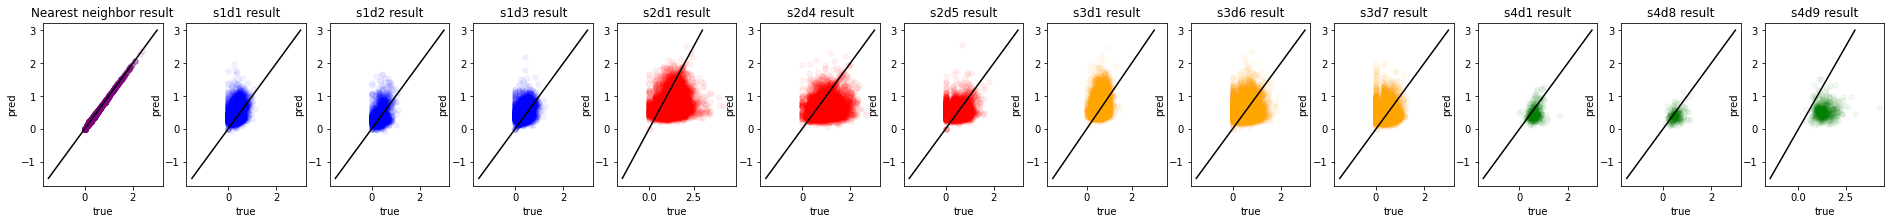

Epoch  36100 near loss: 0.0042736586 s1d1:  0.2881872 s1d2:  0.2217831 s1d3:  0.25978655 s2d1: 0.70892096 s2d4: 0.5636361 s2d5: 0.3373259 s3d1: 0.30523625 s3d6: 0.3660674 s3d7: 0.32149667 s4d1: 0.26959202 s4d8: 0.28554013 s4d9: 0.9178143 test loss: 0.6540690137738838
Epoch  36200 near loss: 0.002731609 s1d1:  0.2905871 s1d2:  0.22303624 s1d3:  0.2619419 s2d1: 0.7061458 s2d4: 0.561771 s2d5: 0.33915704 s3d1: 0.30638525 s3d6: 0.36721122 s3d7: 0.3231382 s4d1: 0.26902378 s4d8: 0.28514504 s4d9: 0.91394997 test loss: 0.6514662935849541
Epoch  36300 near loss: 0.0025743917 s1d1:  0.2897882 s1d2:  0.22266097 s1d3:  0.26094392 s2d1: 0.70874816 s2d4: 0.5633192 s2d5: 0.33762082 s3d1: 0.3053882 s3d6: 0.36668482 s3d7: 0.321876 s4d1: 0.2698215 s4d8: 0.2856225 s4d9: 0.9168754 test loss: 0.6535034008615765
Epoch  36400 near loss: 0.004138801 s1d1:  0.29235572 s1d2:  0.22414121 s1d3:  0.263191 s2d1: 0.70566607 s2d4: 0.5614161 s2d5: 0.33957893 s3d1: 0.30772945 s3d6: 0.36796224 s3d7: 0.32379994 s4d1: 0.26

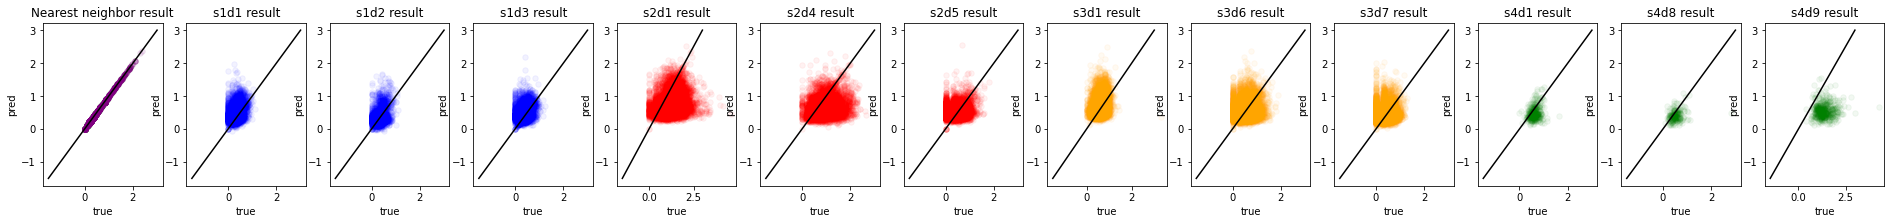

Epoch  37100 near loss: 0.0026303665 s1d1:  0.2901221 s1d2:  0.22289184 s1d3:  0.2614912 s2d1: 0.70736873 s2d4: 0.56311446 s2d5: 0.33817777 s3d1: 0.30611438 s3d6: 0.36686313 s3d7: 0.32218185 s4d1: 0.26941276 s4d8: 0.2850493 s4d9: 0.9158599 test loss: 0.6527411963553273
Epoch  37200 near loss: 0.0026981481 s1d1:  0.2899611 s1d2:  0.22292411 s1d3:  0.2612613 s2d1: 0.7079008 s2d4: 0.5631682 s2d5: 0.3378747 s3d1: 0.30656934 s3d6: 0.36711037 s3d7: 0.32246336 s4d1: 0.2698647 s4d8: 0.2854997 s4d9: 0.9168713 test loss: 0.6534956142294147
Epoch  37300 near loss: 0.002742896 s1d1:  0.2905787 s1d2:  0.22307868 s1d3:  0.26164094 s2d1: 0.7080174 s2d4: 0.56315017 s2d5: 0.3377775 s3d1: 0.30620334 s3d6: 0.3669569 s3d7: 0.32228032 s4d1: 0.26985323 s4d8: 0.28555173 s4d9: 0.91675496 test loss: 0.6534238167271447
Epoch  37400 near loss: 0.0026606603 s1d1:  0.29054102 s1d2:  0.22311826 s1d3:  0.26179957 s2d1: 0.70619094 s2d4: 0.5617542 s2d5: 0.3391677 s3d1: 0.30656636 s3d6: 0.36733323 s3d7: 0.32313856 s4d1

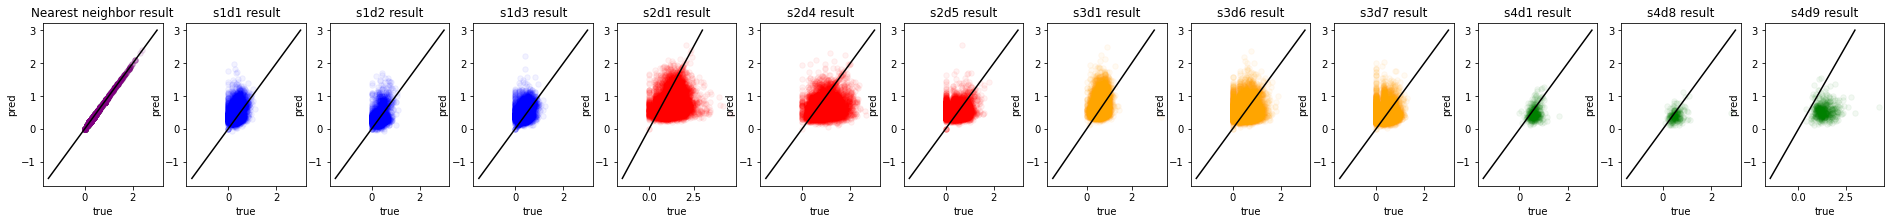

Epoch  38100 near loss: 0.0023663354 s1d1:  0.29066846 s1d2:  0.223392 s1d3:  0.26227945 s2d1: 0.70659924 s2d4: 0.5619348 s2d5: 0.33874354 s3d1: 0.30622438 s3d6: 0.3671184 s3d7: 0.32296544 s4d1: 0.26940697 s4d8: 0.2853373 s4d9: 0.91471165 test loss: 0.6520270419802012
Epoch  38200 near loss: 0.006890614 s1d1:  0.29226586 s1d2:  0.224123 s1d3:  0.26351988 s2d1: 0.7039033 s2d4: 0.5600134 s2d5: 0.34065464 s3d1: 0.30725342 s3d6: 0.36813304 s3d7: 0.32445565 s4d1: 0.26811343 s4d8: 0.28431132 s4d9: 0.91026497 test loss: 0.6488922966784892
Epoch  38300 near loss: 0.0022552307 s1d1:  0.29077548 s1d2:  0.22346973 s1d3:  0.26208514 s2d1: 0.70795864 s2d4: 0.5629733 s2d5: 0.33775705 s3d1: 0.3063629 s3d6: 0.36716 s3d7: 0.32253283 s4d1: 0.27009806 s4d8: 0.28582227 s4d9: 0.91682726 test loss: 0.6535286390134025
Epoch  38400 near loss: 0.005081988 s1d1:  0.28748283 s1d2:  0.22175221 s1d3:  0.25935018 s2d1: 0.7095652 s2d4: 0.56391 s2d5: 0.336923 s3d1: 0.30416912 s3d6: 0.36578652 s3d7: 0.32121915 s4d1: 0

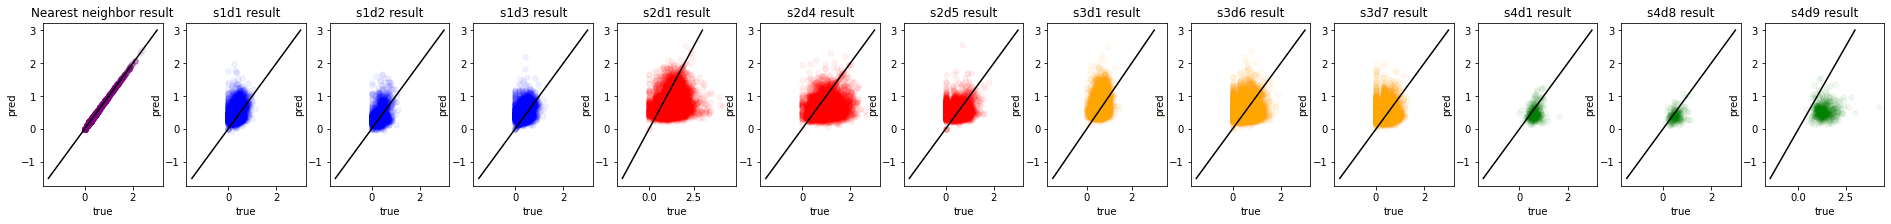

Epoch  39100 near loss: 0.002486929 s1d1:  0.28977135 s1d2:  0.22309707 s1d3:  0.26162893 s2d1: 0.70784664 s2d4: 0.562916 s2d5: 0.33800977 s3d1: 0.30546558 s3d6: 0.36658728 s3d7: 0.3223009 s4d1: 0.2697626 s4d8: 0.28555128 s4d9: 0.916165 test loss: 0.6530313403733337
Epoch  39200 near loss: 0.005122717 s1d1:  0.28839165 s1d2:  0.22242568 s1d3:  0.26045027 s2d1: 0.7099686 s2d4: 0.5643155 s2d5: 0.33659676 s3d1: 0.304705 s3d6: 0.36619532 s3d7: 0.32108042 s4d1: 0.27048448 s4d8: 0.2858757 s4d9: 0.9189168 test loss: 0.6549324094170154
Epoch  39300 near loss: 0.0030809962 s1d1:  0.28960186 s1d2:  0.22304793 s1d3:  0.2614557 s2d1: 0.70842683 s2d4: 0.56311375 s2d5: 0.33750072 s3d1: 0.30557442 s3d6: 0.36680937 s3d7: 0.3221755 s4d1: 0.27008224 s4d8: 0.28546432 s4d9: 0.91684496 test loss: 0.6535054533600653
Epoch  39400 near loss: 0.003327508 s1d1:  0.2889306 s1d2:  0.2229051 s1d3:  0.26094994 s2d1: 0.70910716 s2d4: 0.5637999 s2d5: 0.3372473 s3d1: 0.30506492 s3d6: 0.36647353 s3d7: 0.32160276 s4d1: 

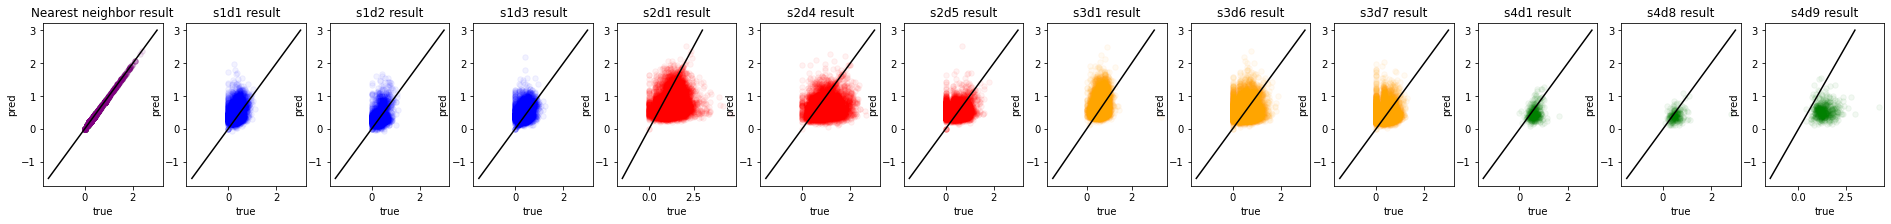

Epoch  40100 near loss: 0.005198235 s1d1:  0.2879875 s1d2:  0.22227706 s1d3:  0.26001823 s2d1: 0.71080506 s2d4: 0.5646254 s2d5: 0.33624676 s3d1: 0.30422905 s3d6: 0.3660294 s3d7: 0.32077682 s4d1: 0.27031446 s4d8: 0.28570625 s4d9: 0.91887313 test loss: 0.6548654988529024
Epoch  40200 near loss: 0.0033500574 s1d1:  0.2917718 s1d2:  0.22404023 s1d3:  0.26334402 s2d1: 0.7051482 s2d4: 0.5611344 s2d5: 0.33952212 s3d1: 0.3070436 s3d6: 0.36749712 s3d7: 0.32362247 s4d1: 0.26840436 s4d8: 0.28413597 s4d9: 0.9120022 test loss: 0.6500352136250305
Epoch  40300 near loss: 0.006512249 s1d1:  0.2881446 s1d2:  0.2223077 s1d3:  0.26022875 s2d1: 0.7096514 s2d4: 0.5639776 s2d5: 0.3366256 s3d1: 0.30417138 s3d6: 0.365982 s3d7: 0.32109743 s4d1: 0.27002642 s4d8: 0.2856745 s4d9: 0.9183333 test loss: 0.6544752588533125
Epoch  40400 near loss: 0.0033674415 s1d1:  0.29207462 s1d2:  0.22430345 s1d3:  0.26356888 s2d1: 0.7050484 s2d4: 0.5610194 s2d5: 0.33966103 s3d1: 0.30681798 s3d6: 0.36779034 s3d7: 0.32370958 s4d1: 

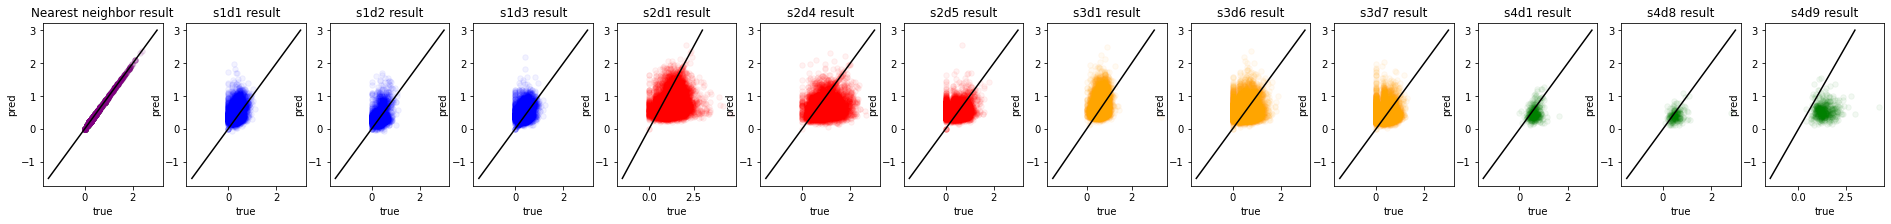

Epoch  41100 near loss: 0.003986007 s1d1:  0.28889725 s1d2:  0.22251327 s1d3:  0.26068255 s2d1: 0.70918673 s2d4: 0.5635975 s2d5: 0.33704785 s3d1: 0.3050473 s3d6: 0.3664916 s3d7: 0.32127 s4d1: 0.2696233 s4d8: 0.2851593 s4d9: 0.9165143 test loss: 0.6532016227519201
Epoch  41200 near loss: 0.0036670368 s1d1:  0.29153416 s1d2:  0.22398496 s1d3:  0.26333326 s2d1: 0.705427 s2d4: 0.561016 s2d5: 0.33948687 s3d1: 0.30613056 s3d6: 0.36739936 s3d7: 0.32328588 s4d1: 0.2683406 s4d8: 0.28449574 s4d9: 0.91211057 test loss: 0.6501287682898874
Epoch  41300 near loss: 0.003992744 s1d1:  0.29190797 s1d2:  0.22420713 s1d3:  0.2636278 s2d1: 0.7047773 s2d4: 0.5608721 s2d5: 0.33986214 s3d1: 0.30707884 s3d6: 0.36777747 s3d7: 0.32383376 s4d1: 0.26832068 s4d8: 0.28443563 s4d9: 0.9115226 test loss: 0.6497419815318635
Epoch  41400 near loss: 0.0019785804 s1d1:  0.29011548 s1d2:  0.22341706 s1d3:  0.26213583 s2d1: 0.70648676 s2d4: 0.5619336 s2d5: 0.3388221 s3d1: 0.30574355 s3d6: 0.36706442 s3d7: 0.32277727 s4d1: 0

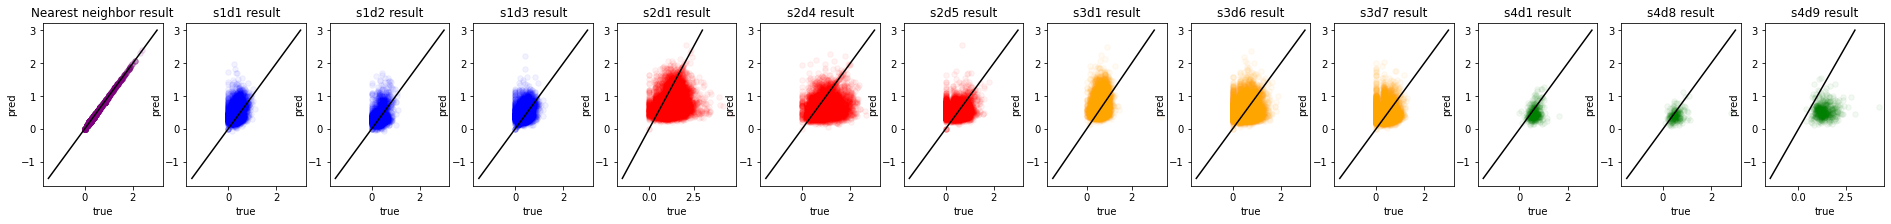

Epoch  42100 near loss: 0.0022326452 s1d1:  0.2908315 s1d2:  0.22392729 s1d3:  0.26278988 s2d1: 0.7065776 s2d4: 0.5617137 s2d5: 0.3387078 s3d1: 0.3055785 s3d6: 0.36696148 s3d7: 0.32281035 s4d1: 0.26896515 s4d8: 0.2847478 s4d9: 0.9135162 test loss: 0.6511429155176851
Epoch  42200 near loss: 0.0028896495 s1d1:  0.29038414 s1d2:  0.2236454 s1d3:  0.26257762 s2d1: 0.7074762 s2d4: 0.562297 s2d5: 0.33822665 s3d1: 0.30489463 s3d6: 0.3665505 s3d7: 0.3222405 s4d1: 0.2690191 s4d8: 0.28489307 s4d9: 0.9145589 test loss: 0.651834960752057
Epoch  42300 near loss: 0.003230297 s1d1:  0.2897613 s1d2:  0.2234016 s1d3:  0.26203835 s2d1: 0.70857304 s2d4: 0.56357837 s2d5: 0.33756733 s3d1: 0.30496135 s3d6: 0.36648932 s3d7: 0.32184014 s4d1: 0.27012742 s4d8: 0.28569913 s4d9: 0.9171566 test loss: 0.6537336103076584
Epoch  42400 near loss: 0.001981139 s1d1:  0.29112324 s1d2:  0.22404689 s1d3:  0.2630023 s2d1: 0.706355 s2d4: 0.561728 s2d5: 0.33885872 s3d1: 0.3056424 s3d6: 0.36701787 s3d7: 0.323066 s4d1: 0.268817

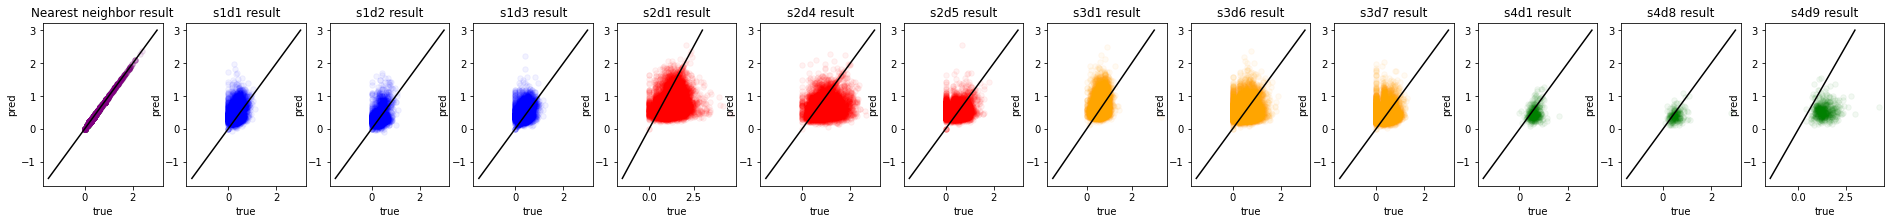

Epoch  43100 near loss: 0.004973592 s1d1:  0.28768066 s1d2:  0.22241148 s1d3:  0.26037022 s2d1: 0.709669 s2d4: 0.5642108 s2d5: 0.3368547 s3d1: 0.30414832 s3d6: 0.36589256 s3d7: 0.32102966 s4d1: 0.2701145 s4d8: 0.28603038 s4d9: 0.91819674 test loss: 0.6544316225024753
Epoch  43200 near loss: 0.0032568441 s1d1:  0.28875625 s1d2:  0.22290502 s1d3:  0.2611662 s2d1: 0.70794415 s2d4: 0.5627953 s2d5: 0.33793667 s3d1: 0.3043011 s3d6: 0.3662391 s3d7: 0.32195592 s4d1: 0.26917922 s4d8: 0.28558654 s4d9: 0.9159369 test loss: 0.6528072285473565
Epoch  43300 near loss: 0.0031466756 s1d1:  0.28955838 s1d2:  0.22342207 s1d3:  0.26187727 s2d1: 0.7085275 s2d4: 0.56341714 s2d5: 0.33741167 s3d1: 0.3052148 s3d6: 0.366561 s3d7: 0.32183215 s4d1: 0.27001283 s4d8: 0.28559828 s4d9: 0.91712654 test loss: 0.6536893209388632
Epoch  43400 near loss: 0.0036788092 s1d1:  0.2899504 s1d2:  0.22345458 s1d3:  0.26198742 s2d1: 0.7086611 s2d4: 0.5633415 s2d5: 0.3373027 s3d1: 0.30485374 s3d6: 0.36663532 s3d7: 0.32191673 s4d1

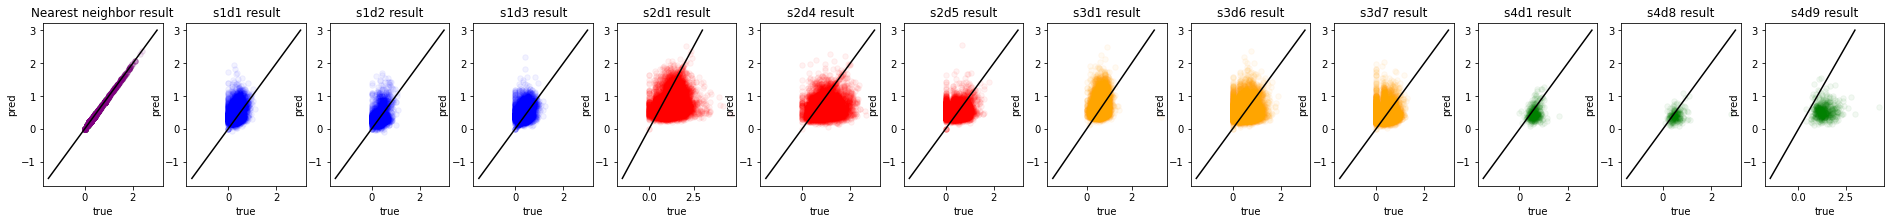

Epoch  44100 near loss: 0.0059903236 s1d1:  0.28739166 s1d2:  0.22214392 s1d3:  0.26016924 s2d1: 0.7095629 s2d4: 0.56377333 s2d5: 0.33682883 s3d1: 0.3032552 s3d6: 0.36544374 s3d7: 0.3207255 s4d1: 0.26970255 s4d8: 0.28568774 s4d9: 0.9182061 test loss: 0.6543499287176432
Epoch  44200 near loss: 0.0032193956 s1d1:  0.28924933 s1d2:  0.22309245 s1d3:  0.26156738 s2d1: 0.7082226 s2d4: 0.56267613 s2d5: 0.33767763 s3d1: 0.30439034 s3d6: 0.36635295 s3d7: 0.32173213 s4d1: 0.26932594 s4d8: 0.285111 s4d9: 0.9156776 test loss: 0.6526174190589557
Epoch  44300 near loss: 0.0022547264 s1d1:  0.2899945 s1d2:  0.22319718 s1d3:  0.26207796 s2d1: 0.7068381 s2d4: 0.5618255 s2d5: 0.33843184 s3d1: 0.30530664 s3d6: 0.36675465 s3d7: 0.32249495 s4d1: 0.26875404 s4d8: 0.28459954 s4d9: 0.91400623 test loss: 0.6514159499965343
Epoch  44400 near loss: 0.0019635917 s1d1:  0.2892982 s1d2:  0.2230994 s1d3:  0.2615313 s2d1: 0.70757717 s2d4: 0.5622693 s2d5: 0.338129 s3d1: 0.30478126 s3d6: 0.366641 s3d7: 0.32218638 s4d1

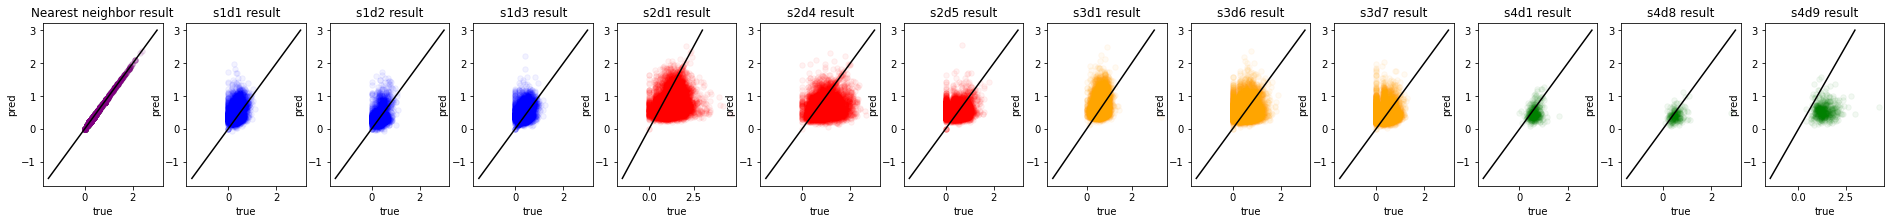

Epoch  45100 near loss: 0.003021532 s1d1:  0.2900857 s1d2:  0.22352816 s1d3:  0.26239505 s2d1: 0.7077396 s2d4: 0.56208855 s2d5: 0.3379858 s3d1: 0.3044239 s3d6: 0.36641967 s3d7: 0.32209754 s4d1: 0.26892492 s4d8: 0.28466752 s4d9: 0.91441584 test loss: 0.6517094433274772
Epoch  45200 near loss: 0.0038476791 s1d1:  0.28916574 s1d2:  0.22298998 s1d3:  0.26157427 s2d1: 0.7088081 s2d4: 0.5630296 s2d5: 0.3373463 s3d1: 0.304199 s3d6: 0.3662461 s3d7: 0.32144064 s4d1: 0.2694128 s4d8: 0.28522718 s4d9: 0.91619456 test loss: 0.6529728257480402
Epoch  45300 near loss: 0.0028429662 s1d1:  0.29121137 s1d2:  0.22399624 s1d3:  0.263309 s2d1: 0.70531774 s2d4: 0.56072855 s2d5: 0.33950394 s3d1: 0.30503848 s3d6: 0.3670186 s3d7: 0.3233064 s4d1: 0.26833996 s4d8: 0.28414634 s4d9: 0.9116514 test loss: 0.6498013452455993
Epoch  45400 near loss: 0.0035909468 s1d1:  0.29084387 s1d2:  0.22383794 s1d3:  0.26287818 s2d1: 0.70572 s2d4: 0.5608831 s2d5: 0.3392472 s3d1: 0.30530074 s3d6: 0.36730325 s3d7: 0.32317606 s4d1: 0

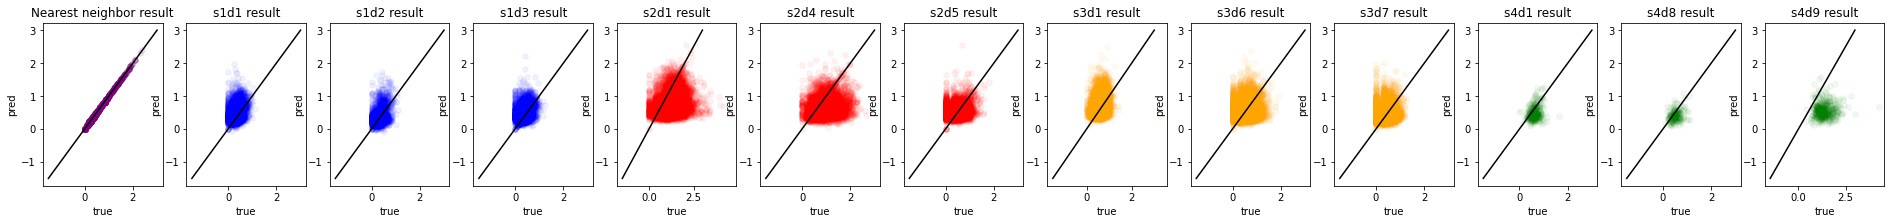

Epoch  46100 near loss: 0.0027965077 s1d1:  0.2910051 s1d2:  0.22404024 s1d3:  0.26331082 s2d1: 0.7059296 s2d4: 0.5608835 s2d5: 0.33904898 s3d1: 0.3053724 s3d6: 0.36713296 s3d7: 0.3229809 s4d1: 0.26823923 s4d8: 0.2840369 s4d9: 0.9119484 test loss: 0.6499688230944393
Epoch  46200 near loss: 0.008579592 s1d1:  0.2863406 s1d2:  0.22183043 s1d3:  0.25935438 s2d1: 0.71173924 s2d4: 0.5648915 s2d5: 0.33550376 s3d1: 0.30262795 s3d6: 0.36522284 s3d7: 0.3199284 s4d1: 0.2708226 s4d8: 0.2862095 s4d9: 0.92037755 test loss: 0.6559499275546398
Epoch  46300 near loss: 0.0032069338 s1d1:  0.29121533 s1d2:  0.22401738 s1d3:  0.26327342 s2d1: 0.7054445 s2d4: 0.56081265 s2d5: 0.33924377 s3d1: 0.30569065 s3d6: 0.3674705 s3d7: 0.323335 s4d1: 0.26864508 s4d8: 0.28443787 s4d9: 0.91159827 test loss: 0.6498356657151341
Epoch  46400 near loss: 0.0033871045 s1d1:  0.28963992 s1d2:  0.22332852 s1d3:  0.2622297 s2d1: 0.7073664 s2d4: 0.5623764 s2d5: 0.33810923 s3d1: 0.30474845 s3d6: 0.36661816 s3d7: 0.32201347 s4d1:

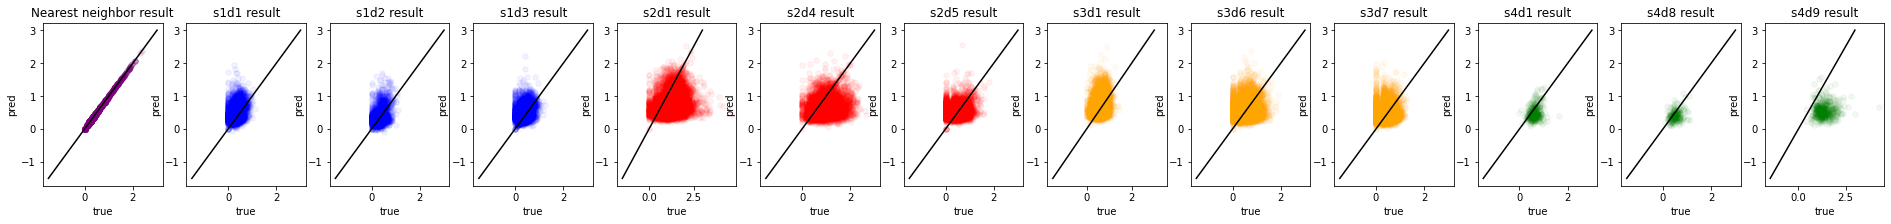

Epoch  47100 near loss: 0.0042437958 s1d1:  0.28897467 s1d2:  0.22306184 s1d3:  0.26178598 s2d1: 0.70899117 s2d4: 0.56368357 s2d5: 0.3371727 s3d1: 0.30396825 s3d6: 0.3662391 s3d7: 0.32114112 s4d1: 0.27017775 s4d8: 0.2856962 s4d9: 0.91650254 test loss: 0.6533191350689643
Epoch  47200 near loss: 0.002042879 s1d1:  0.2909779 s1d2:  0.22410136 s1d3:  0.26348338 s2d1: 0.70598185 s2d4: 0.56126714 s2d5: 0.33897582 s3d1: 0.3048386 s3d6: 0.36701173 s3d7: 0.32278144 s4d1: 0.26884377 s4d8: 0.28447142 s4d9: 0.9121096 test loss: 0.6501953845082796
Epoch  47300 near loss: 0.006357088 s1d1:  0.28801996 s1d2:  0.22270826 s1d3:  0.26081246 s2d1: 0.7099917 s2d4: 0.5643771 s2d5: 0.3365068 s3d1: 0.3035501 s3d6: 0.36591783 s3d7: 0.32078102 s4d1: 0.27087137 s4d8: 0.28612423 s4d9: 0.91856796 test loss: 0.6547836287364737
Epoch  47400 near loss: 0.002947337 s1d1:  0.29125696 s1d2:  0.22397386 s1d3:  0.26322943 s2d1: 0.7054837 s2d4: 0.5608859 s2d5: 0.33928838 s3d1: 0.30574563 s3d6: 0.36733744 s3d7: 0.3232144 s

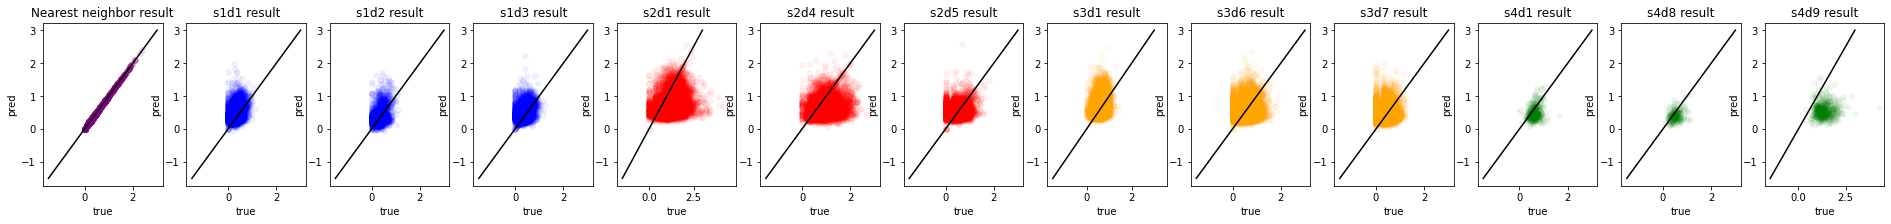

Epoch  48100 near loss: 0.0022464497 s1d1:  0.2900184 s1d2:  0.22375362 s1d3:  0.26240543 s2d1: 0.70657825 s2d4: 0.56149286 s2d5: 0.33861074 s3d1: 0.30449662 s3d6: 0.3667916 s3d7: 0.32233024 s4d1: 0.26888442 s4d8: 0.28494227 s4d9: 0.9127376 test loss: 0.650648031091637
Epoch  48200 near loss: 0.0054387515 s1d1:  0.29019395 s1d2:  0.22372068 s1d3:  0.26256722 s2d1: 0.7085944 s2d4: 0.5629666 s2d5: 0.33705416 s3d1: 0.3041684 s3d6: 0.36637503 s3d7: 0.32155296 s4d1: 0.26940274 s4d8: 0.2848333 s4d9: 0.9154033 test loss: 0.6524262631364334
Epoch  48300 near loss: 0.0019167982 s1d1:  0.29117554 s1d2:  0.22430661 s1d3:  0.26363456 s2d1: 0.7063731 s2d4: 0.5615982 s2d5: 0.3386626 s3d1: 0.30520836 s3d6: 0.36706534 s3d7: 0.322649 s4d1: 0.26922214 s4d8: 0.2848714 s4d9: 0.9131553 test loss: 0.65095720127292
Epoch  48400 near loss: 0.0060692183 s1d1:  0.29315686 s1d2:  0.22518879 s1d3:  0.26507697 s2d1: 0.7030986 s2d4: 0.559446 s2d5: 0.34083 s3d1: 0.30677027 s3d6: 0.36829624 s3d7: 0.32454374 s4d1: 0.2

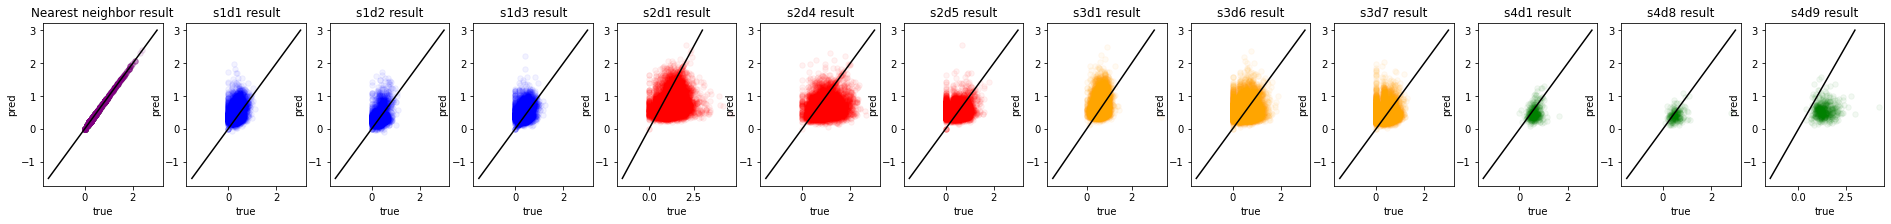

Epoch  49100 near loss: 0.0021852227 s1d1:  0.29032123 s1d2:  0.22376938 s1d3:  0.2628675 s2d1: 0.706799 s2d4: 0.5617689 s2d5: 0.3385167 s3d1: 0.30401945 s3d6: 0.3667463 s3d7: 0.32219064 s4d1: 0.26937923 s4d8: 0.28504124 s4d9: 0.91316134 test loss: 0.6509981619235611
Epoch  49200 near loss: 0.0023911481 s1d1:  0.2913558 s1d2:  0.22420105 s1d3:  0.26367566 s2d1: 0.705479 s2d4: 0.5609298 s2d5: 0.33912423 s3d1: 0.30490208 s3d6: 0.36694562 s3d7: 0.32304314 s4d1: 0.2685111 s4d8: 0.28450343 s4d9: 0.9121759 test loss: 0.6501950544893641
Epoch  49300 near loss: 0.003089908 s1d1:  0.2899675 s1d2:  0.22366534 s1d3:  0.26242465 s2d1: 0.7079325 s2d4: 0.5624986 s2d5: 0.33751076 s3d1: 0.3041239 s3d6: 0.36657292 s3d7: 0.32196054 s4d1: 0.26984704 s4d8: 0.28550565 s4d9: 0.9151955 test loss: 0.6524146126046124
Epoch  49400 near loss: 0.002037796 s1d1:  0.29099995 s1d2:  0.22409299 s1d3:  0.26332447 s2d1: 0.70678043 s2d4: 0.5618393 s2d5: 0.3382938 s3d1: 0.3042909 s3d6: 0.36683378 s3d7: 0.32232258 s4d1: 0

In [41]:
num_epochs = 50000
learning_rate = 0.01
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, input_near, output_near)